# Lab Assignment Five: Wide and Deep Network Architectures

## Dataset Selection

Select a dataset similarly to lab one. That is, the dataset must be table data. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification, multi-class classification, or regression.

I get this Stroke Prediction Dataset from [kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv).

## 1 Preparation (4 points total)
- [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 
- [1 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 
- [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [1]:
%reset -f

In [2]:
#import the library needed
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split
import copy
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import sys
import os
import tempfile
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics as mt
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adagrad,Adam


print('tensorflow version:',tf.__version__)
print('pandas version:',pd.__version__)
print('keras version:',keras.__version__)
print('numpy version:',np.__version__)

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

#which platform right now I located 
# import platform 
# print(platform.system())
# print(platform.release())
# print(platform.version())

tensorflow version: 2.4.1
pandas version: 1.2.4
keras version: 2.4.0
numpy version: 1.19.2


In [3]:
df = pd.read_csv("./data/healthcare-dataset-stroke-data.csv",)
pd.set_option('display.max_columns', None)
df.rename(columns={'Residence_type': 'residence_type'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.head(10)

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   
5        Private          Urban             186.21  29.0  formerly smoked   
6        Private          Rural              70.09  27.4     never smoked   
7        Private          Urban              94.39  22.8     never smoked   
8        Private          Rural              76.15   NaN          Unknown   
9        Private          Urban              58.57  24.2          Unknown   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1

### 1.1 Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

### I drop the column of "id" since it's unrelated to the classification task.

In [5]:
df.drop(['id'],axis=1,inplace=True)

In [6]:
print(df.gender.unique())
print(df.hypertension.unique())
print(df.heart_disease.unique())
print(df.ever_married.unique())
print(df.work_type.unique())
print(df.residence_type.unique())
print(df.smoking_status.unique())

['Male' 'Female' 'Other']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [7]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

### Only one record of gender is "Other" so I choose to drop it.

In [8]:
df.drop(df[df.gender=='Other'].index,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


### There are 201 missing data in the column "bmi", I would drop them because I don't want to introduce bias into this dataset.

In [10]:
print(df.isna().sum())
df.dropna(inplace=True)
df.info()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   object 
 1   age                4908 non-null   float64
 2   hypertension       4908 non-null   int64  
 3   heart_disease      4908 non-null   int64  
 4   ever_married       4908 non-null   object 
 5   work_type          4908 non-null   object 
 6   residence_type     4908 non-null   object 
 7   avg_glucose_level  4908 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     4908 non-null   object 
 10  stroke             4908 

### In order to make the column avg_glucose_level more representative, I would use it to generate 3 classes, which are normal, prediabetes and diabetes because average glucose level could be utilized for diabetes diagnosis and diabetes are associated with stroke. Based on the searched information from Mayo Clinic's website, a blood sugar level less than 140 mg/dL (7.8 mmol/L) is normal. A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes. A reading between 140 and 199 mg/dL (7.8 mmol/L and 11.0 mmol/L) indicates prediabetes. Hence, the average glucose level is classified as 3 classes by this method.

In [11]:
df['diabetes'] = np.select([df['avg_glucose_level'] < 140, df['avg_glucose_level'].between(140, 200), df['avg_glucose_level'] >= 200], ['normal', 'prediabetes', 'diabetes'])

In [12]:
# I change columns of hypertension and heart_disease into string data for the sake of processing batch lable encoding.
df['hypertension'] = np.select([df['hypertension'] == 1, df['hypertension']==0 ],['Yes','No'])
df['heart_disease'] = np.select([df['heart_disease'] == 1, df['heart_disease']==0 ],['Yes','No'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   object 
 1   age                4908 non-null   float64
 2   hypertension       4908 non-null   object 
 3   heart_disease      4908 non-null   object 
 4   ever_married       4908 non-null   object 
 5   work_type          4908 non-null   object 
 6   residence_type     4908 non-null   object 
 7   avg_glucose_level  4908 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     4908 non-null   object 
 10  stroke             4908 non-null   int64  
 11  diabetes           4908 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 498.5+ KB


### I have 8 categorical data(gender, hypertension, heart_disease, ever_married, work_type, Residence_type, smoking_status, diabetes), they all need to be encoded as int data, which are gender,ever_married,work_type,Residence_type,smoking_status

In [14]:
categorical_headers = ['gender','hypertension','heart_disease','ever_married','work_type','residence_type','smoking_status','diabetes']

In [15]:
lable_encoders = dict()
for col in categorical_headers:
    lable_encoders[col] = LabelEncoder()
    df[col+'_int'] = lable_encoders[col].fit_transform(df[col])

### To scale the numeric, continuous variables(age,bmi)

In [16]:
numeric_headers = ['age','bmi','avg_glucose_level']
for col in numeric_headers:
    df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1, 1))

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4908 non-null   object 
 1   age                 4908 non-null   float64
 2   hypertension        4908 non-null   object 
 3   heart_disease       4908 non-null   object 
 4   ever_married        4908 non-null   object 
 5   work_type           4908 non-null   object 
 6   residence_type      4908 non-null   object 
 7   avg_glucose_level   4908 non-null   float64
 8   bmi                 4908 non-null   float64
 9   smoking_status      4908 non-null   object 
 10  stroke              4908 non-null   int64  
 11  diabetes            4908 non-null   object 
 12  gender_int          4908 non-null   int64  
 13  hypertension_int    4908 non-null   int64  
 14  heart_disease_int   4908 non-null   int64  
 15  ever_married_int    4908 non-null   int64  
 16  work_t

In [18]:
categorical_headers_ints = [x+'_int' for x in categorical_headers]
feature_columns = categorical_headers_ints+numeric_headers
print(feature_columns)

['gender_int', 'hypertension_int', 'heart_disease_int', 'ever_married_int', 'work_type_int', 'residence_type_int', 'smoking_status_int', 'diabetes_int', 'age', 'bmi', 'avg_glucose_level']


In [19]:
for col in categorical_headers:
    if col in lable_encoders:
        print(col,": ",df[col+'_int'].unique())
        print(lable_encoders[col].inverse_transform(df[col+'_int'].unique()))

gender :  [1 0]
['Male' 'Female']
hypertension :  [0 1]
['No' 'Yes']
heart_disease :  [1 0]
['Yes' 'No']
ever_married :  [1 0]
['Yes' 'No']
work_type :  [2 3 0 4 1]
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
residence_type :  [1 0]
['Urban' 'Rural']
smoking_status :  [1 2 3 0]
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
diabetes :  [0 1 2]
['diabetes' 'normal' 'prediabetes']


The data is organized as follows: 

|Variable | description|
|----|--------|
|gender:      |Female, Male.|
|gender_int:      |Female as 0, Male as 1.|
|age:         |age of the patient,continuous.|
|hypertension:      | no if the patient doesn't have hypertension, yes if the patient has hypertension|
|hypertension_int:      |0 if the patient doesn't have hypertension, 1 if the patient has hypertension|
|heart_disease:  |no if the patient doesn't have any heart diseases, no if the patient has a heart disease|
|heart_disease_int:  |0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease|
|ever_married: |No ,Yes |
|ever_married_int: |No as 0, Yes as 1 |
|work_type:     |"children", "Govt_jov", "Never_worked", "Private", "Self-employed"|
|work_type_int:     |"children" as 4, "Govt_jov" as 0, "Never_worked" as 1, "Private" as 2 , "Self-employed" as 3|
|residence_type:   | "Rural" , "Urban"|
|residence_type_int:   | "Rural" as 0 , "Urban" as 1|
|avg_glucose_level:           |average glucose level in blood,continuous|
|bmi:            |body mass index,continuous|
|smoking_status:   |"formerly smoked", "never smoked", "smokes" ,"Unknown" |
|smoking_status_int:   |"formerly smoked" as 1, "never smoked" as 2, "smokes" as 3 ,"Unknown" as 0|
|diabetes:   |"normal" , "prediabetes", "diabetes" |
|diabetes:   |"normal" as 1, "prediabetes" as 2, "diabetes" as 1|
|stroke:   |1 if the patient had a stroke or 0 if not|

### I use this dataset to predict whether a patient is likely to get stroke based on input parameters such as gender, age, hypertension, heart disease, ever-married, work type, residence type, average glucose level, BMI and smoking staus. Its application scenario is just for self-checking. It's a binary classification task and all I can tell is that you are possible or not to have a stroke. In other words, I do not provide possibility such as how many percents you may have a stroke.

### 1.2 Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 

### First, I would like to combine hypertension, heart disease, diabetes and smoking status into cross-product features, because they are factors associated with stroke I read from Harvard Health Publishing. Second, I would combine gender, work_type, ever-married and residence type into cross-product features, since they are indirect factors associated with pressure. As we know, pressure may be associated with some diseases so it worths to have a try in this direction.   

In [20]:
cross_columns = [['hypertension','heart_disease','diabetes','smoking_status'],
                 ['gender','work_type','ever_married','residence_type']
                ]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    X_crossed = df[cols_list].apply(lambda x: '_'.join(x), axis=1)
    cross_col_name = '_'.join(cols_list)
    df[cross_col_name] = LabelEncoder().fit_transform(X_crossed)
    cross_col_df_names.append(cross_col_name) 
    
print(cross_col_df_names)

['hypertension_heart_disease_diabetes_smoking_status', 'gender_work_type_ever_married_residence_type']


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   gender                                              4908 non-null   object 
 1   age                                                 4908 non-null   float64
 2   hypertension                                        4908 non-null   object 
 3   heart_disease                                       4908 non-null   object 
 4   ever_married                                        4908 non-null   object 
 5   work_type                                           4908 non-null   object 
 6   residence_type                                      4908 non-null   object 
 7   avg_glucose_level                                   4908 non-null   float64
 8   bmi                                                 4908 non-null   float64
 9

### 1.3 Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

### The metric I want to use is F1-score. As a self-checking application, both precision and recall are critical. Low precision may bring profound unnessisary anxiety because people likely not to have a stroke may be identified as potential stroke patient. Besides, the dataset has imbalanced classes, 4699 negative cases and 209 positive cases, which means high precision can't ensure to measure the performance of the model. In other words, a useless classifier can get high precision by labeling every sample as negative on this dataset. Hence, both high precision and recall should be guaranteed so F1-score as the harmonic mean of precision and recall is my choice.

pos/neg : 0.04447754841455629
neg: 4699  pos: 209


(array([4699.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         209.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

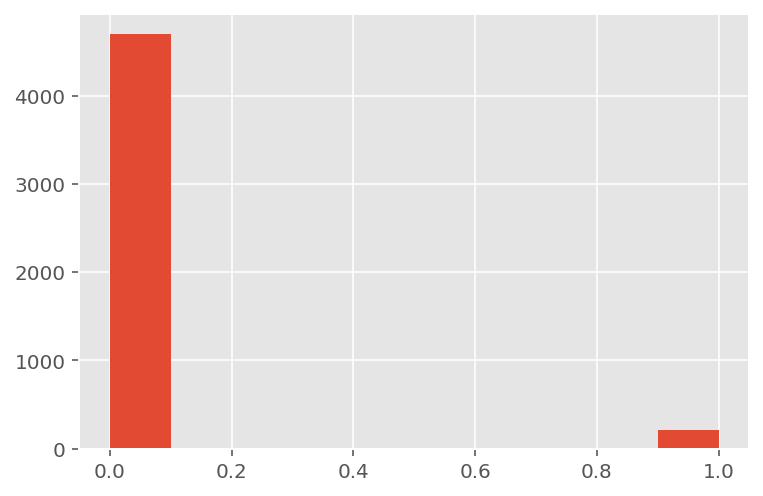

In [22]:
neg,pos = np.bincount(df['stroke'])
print('pos/neg :',pos/neg)
print('neg:',neg,' pos:',pos)
plt.hist(df['stroke'])

### 1.4 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

### I would use Stratified 5-fold cross validation for dividing my data into training and testing since it ensures that the mean target value is approximately equal in all the folds, based on the imbalanced class distribution of this dataset. In other words, I may end up in a rough spot after split if I use hold-out method. For example, I may have 201 positive examples in my training set while get zero in my test set, it's meaningless though how perfect my precision and recall are. 

### I can't say that stratified 5-fold is much better than stratified 10-fold or 6-fold or other else, but I would choose 5-fold instead of 10-fold for the sake of time. That's because more folds means training more models, which needs expensive computation. In addition, my application of self-checking is more like a health reminder, which denotes it would never take place of the diagnosis from doctor, therefore, in my opinion, stratified 5-fold is enough based on this small dataset.

In [23]:
cv = StratifiedKFold(n_splits=5,random_state=5, shuffle=True)

## 2 Modeling (5 points total)
- [2 points] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.
- [2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 
- [1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models.

### 2.1 Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

### 2.2 Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly.

In [24]:
from tensorflow.keras.metrics import Precision, Recall, AUC

# It seems that keras can't import F1-score so instead I use precision and recall as my evaluation metric, however, F1-score could be calculated by precision and recall. I think they are equivalent
# score = [Precision(name='precision'),Recall(name='recall'),TruePositives(name='tp'),TrueNegatives(name='tn'),FalsePositives(name='fp'),FalseNegatives(name='fn')]
score = [Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

### My first model, combined embedding layer, wide layer(cross features are hypertension_heart_disease_diabetes_smoking_status and gender_work_type_ever_married_residence_type) and 2 deep layers.

In [25]:
X = df[feature_columns].to_numpy()
y = df['stroke'].to_numpy()

X_crossed = df[cross_col_df_names].to_numpy()
# save categorical features
X_cat = df[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_num =  df[numeric_headers].to_numpy()

# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                output_dim=int(np.sqrt(N)), 
                input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
# wide_branch = concatenate(crossed_outputs, name='wide_concat')
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                output_dim=int(np.sqrt(N)), 
                input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_num.shape[1],), name='numeric')
x_dense = Dense(units=6, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=20,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep2')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

def make_model1(input_crossed,input_cat,input_num,final_branch):
    model = Model(inputs=[input_crossed,input_cat,input_num], 
                    outputs=final_branch)
    model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=score)
    return model

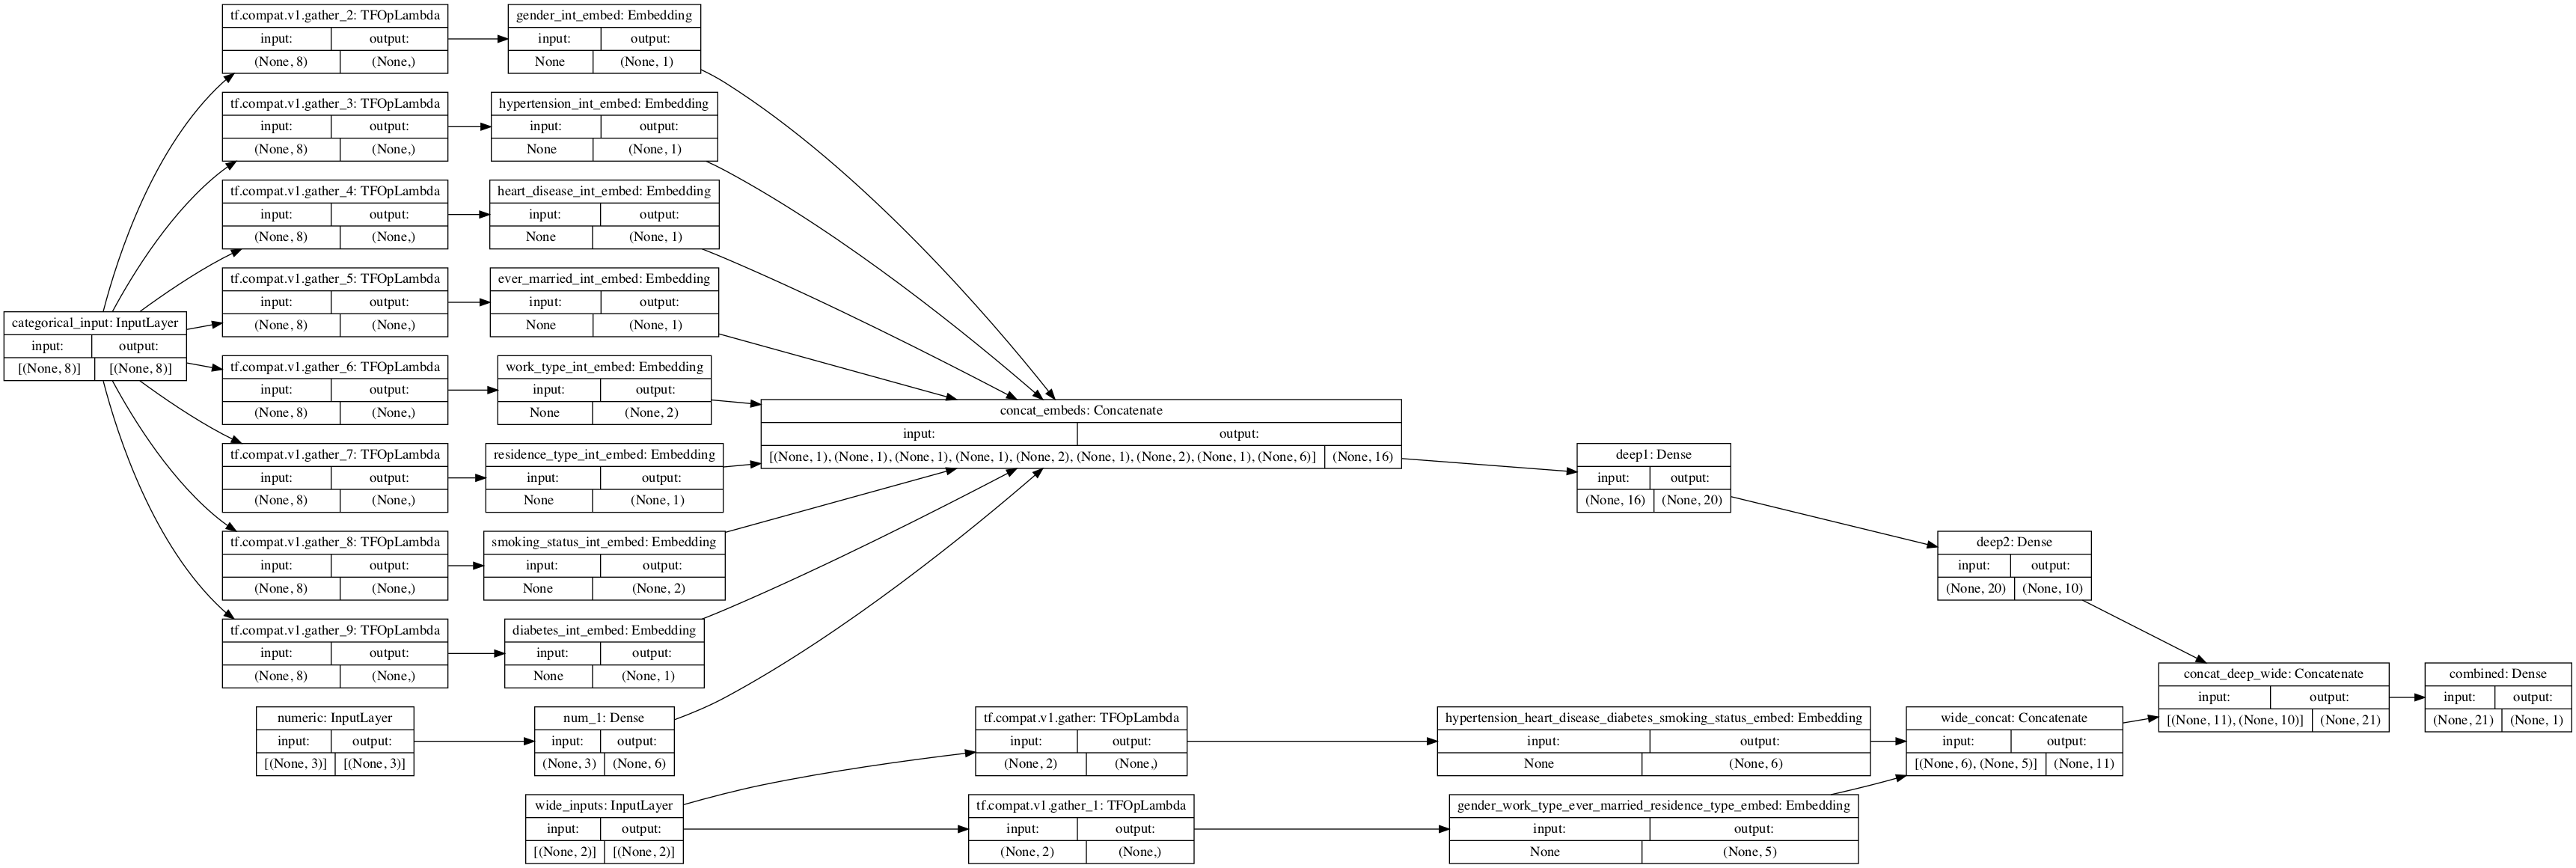

In [26]:
model1 = make_model1(input_crossed,input_cat,input_num,final_branch)
plot_model(
    model1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [27]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_input (InputLayer)  [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.compat.v1.gather_2 (TFOpLamb (None,)              0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf.compat.v1.gather_3 (TFOpLamb (None,)              0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf.compat.v1.gather_4 (TFOpLamb (None,)              0           categorical_input[0][0]          
______________________________________________________________________________________________

### this function is used for plotting the train and validation loss in each epoch

In [28]:
# plot the loss verus each epoch
def plot_loss(history, label):
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],label='Val ' + label,linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [29]:
def plot_metrics(history,label,i):
    metrics = ['loss', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        # plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train ' + label)
        plt.plot(history.epoch, history.history['val_'+metric],linestyle="--", label='Val ' + label)
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric != 'loss':
            plt.ylim([0,1.1])
        plt.title('{} fold {}'.format(metric,i))
        plt.legend()
        plt.show()

In [30]:
def plot_roc(model1_eval,model2_eval,model1_name,model2_name):
    for idx,arr in enumerate(model1_eval['roc']):
        fp1 = model1_eval['roc'][idx][1]
        tp1 = model1_eval['roc'][idx][0]
        fp2 = model2_eval['roc'][idx][1]
        tp2 = model2_eval['roc'][idx][0]
        plt.plot(100*fp1, 100*tp1, label='{} ROC fold {} (AUC {:.3f})'.format(model1_name,idx+1,auc(fp1,tp1)) , linewidth=2)
        plt.plot(100*fp2, 100*tp2, label='{} ROC fold {} (AUC {:.3f})'.format(model2_name,idx+1,auc(fp2,tp2)), linewidth=2, linestyle='--')
        plt.xlabel('False positives [%]')
        plt.ylabel('True positives [%]')
        # plt.xlim([-0.5,20])
        # plt.ylim([80,100.5])
        plt.grid(True)
        ax = plt.gca()
        # ax.set_aspect('equal')
        plt.legend(loc='best')

### I want my model to pay more attention on my examples from minority target class, so I add the different class weight to both majority class and minority class. I find it's much more effective than given equal weight when my dataset is an uneven distribution. The reference formula "wj=n_samples / (n_classes * n_samplesj)" I got from the article [How to Improve Class Imbalance using Class Weights in Machine Learning](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/).

In [31]:
weight_for_0 = (1 / neg)*(pos+neg)/2.0
weight_for_1 = (1 / pos)*(pos+neg)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.5222387742072782, 1: 11.741626794258373}


In [32]:
def evaluate_model(make_model,input_crossed,input_cat,input_num,final_branch,model_name,epochs=100):
    history_arr = []
    cvscore = []
    rocscore = []
    # f1_s = lambda x,y: 0 if x+y==0 else 2*x*y/(x+y)  
    f1_s = lambda x,y: 2*x*y/(x+y)
    i = 0
    for train_index,test_index in cv.split(X,y):
        i += 1
        model = make_model(input_crossed,input_cat,input_num,final_branch)
        if i > 1:
            model.load_weights(initial_weights)
        h = model.fit([X_crossed[train_index],X_cat[train_index],X_num[train_index]],
            y[train_index], 
            epochs=epochs, 
            batch_size=256, 
            verbose=0,
            class_weight = class_weight,
            validation_data = ([X_crossed[test_index],X_cat[test_index],X_num[test_index]],y[test_index]))
        if i == 1:
            initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
            model.save_weights(initial_weights)
        history_arr.append(h)
        cvscore.append(
            [np.mean(h.history['val_precision']),np.mean(h.history['val_recall'])]
        )
        plot_metrics(h,model_name,i)
        # now lets see how well the model performed
        yhat = np.round(model.predict([X_crossed[test_index],X_cat[test_index],X_num[test_index]]))
        fp,tp,_ = mt.roc_curve(y[test_index],yhat)
        rocscore.append([tp,fp])
        print(mt.confusion_matrix(y[test_index],yhat))
        print(mt.classification_report(y[test_index],yhat))
    
    cvscore = np.array(cvscore)
    rocscore = np.array(rocscore)
    f1_measure = f1_s(cvscore[:,0],cvscore[:,1])
    print('{0}: mean precision:{1} and standard deviation:{2}'.format(model_name,np.mean(cvscore[:,0]),np.std(cvscore[:,0])))
    print('{0}: mean recall:{1} and standard deviation:{2}'.format(model_name,np.mean(cvscore[:,1]),np.std(cvscore[:,1])))
    print('{0}: mean f1-score:{1} and standard deviation:{2}'.format(model_name,np.mean(f1_measure),np.std(f1_measure)))
    return {'cv':cvscore,'roc':rocscore,'f1':f1_measure}

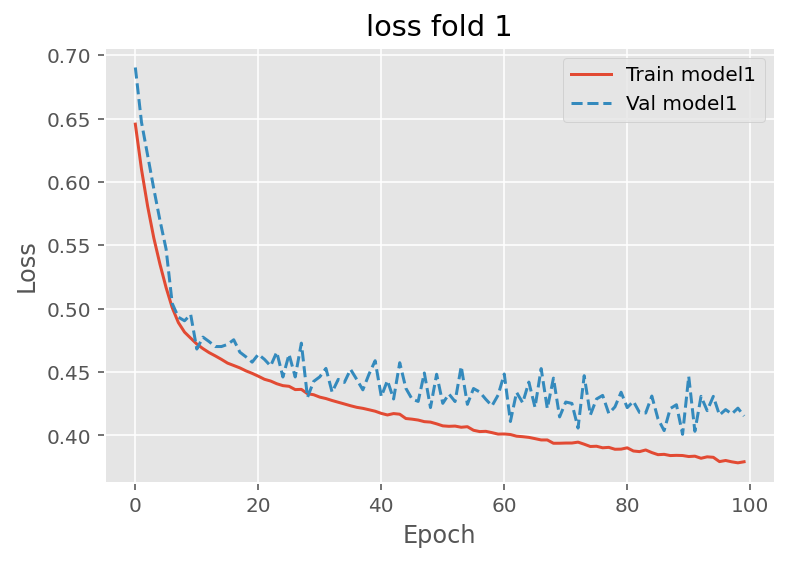

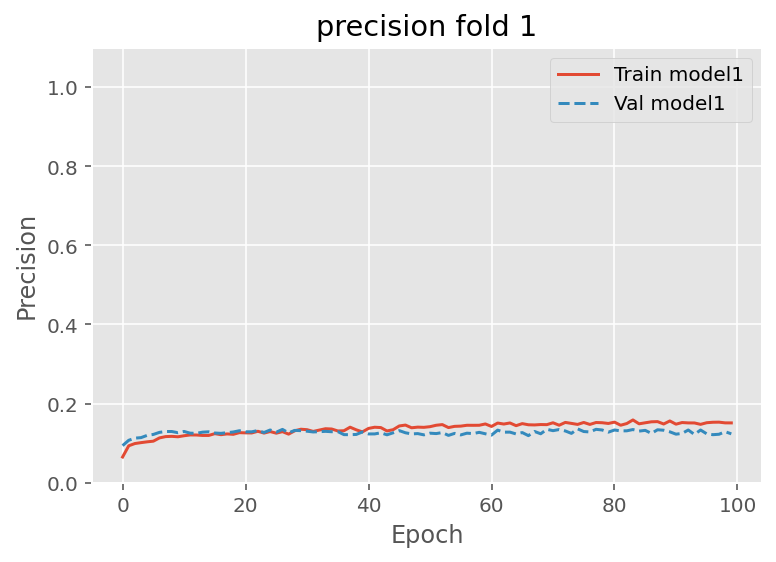

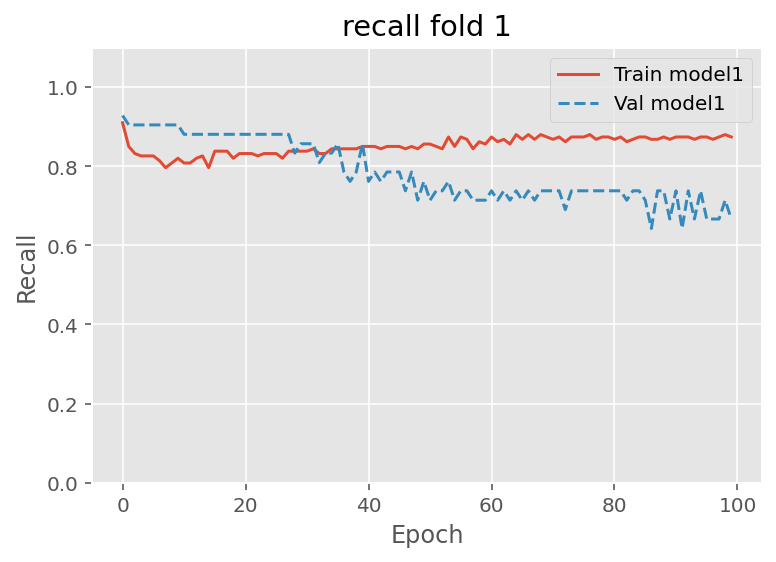

[[741 199]
 [ 14  28]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       940
           1       0.12      0.67      0.21        42

    accuracy                           0.78       982
   macro avg       0.55      0.73      0.54       982
weighted avg       0.94      0.78      0.85       982



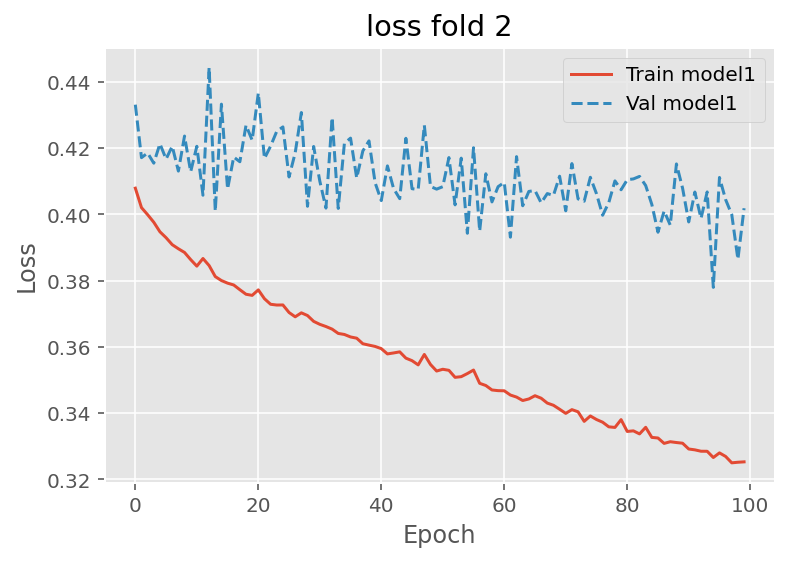

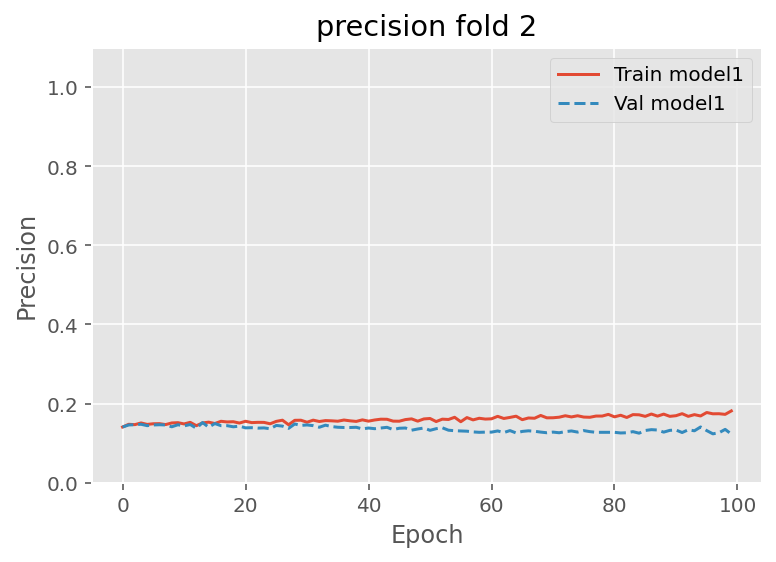

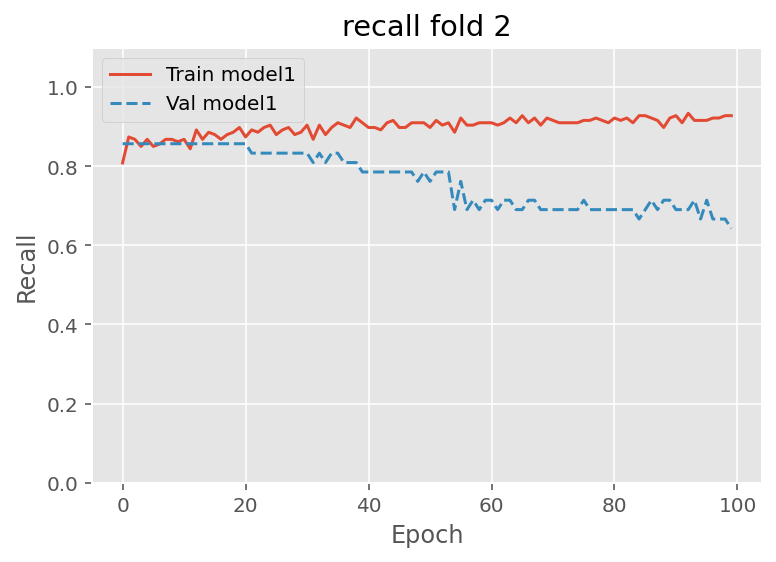

[[747 193]
 [ 15  27]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       940
           1       0.12      0.64      0.21        42

    accuracy                           0.79       982
   macro avg       0.55      0.72      0.54       982
weighted avg       0.94      0.79      0.85       982



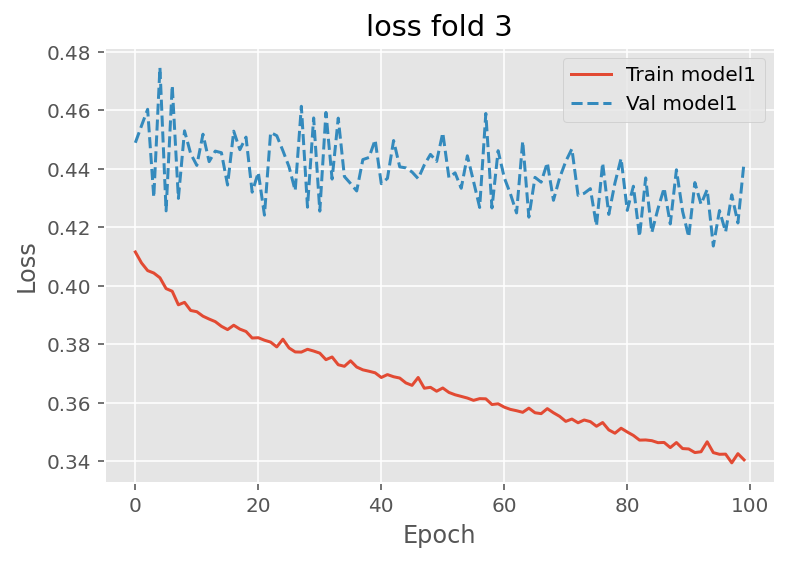

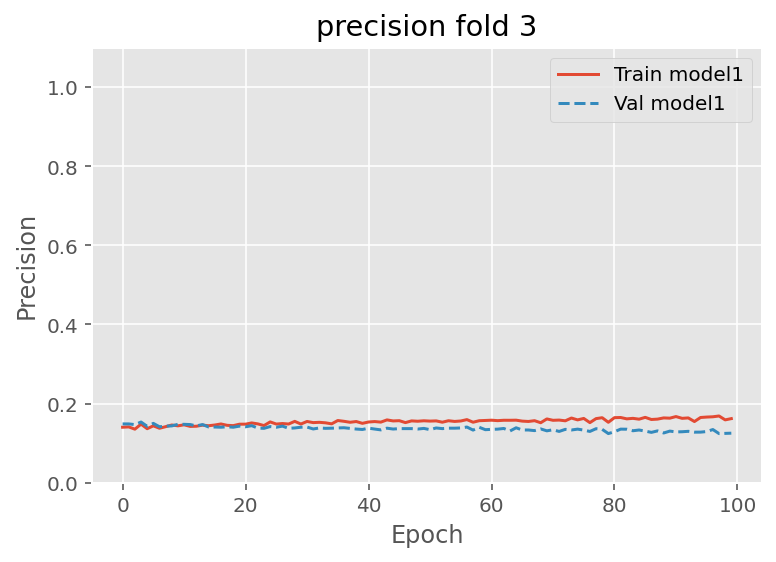

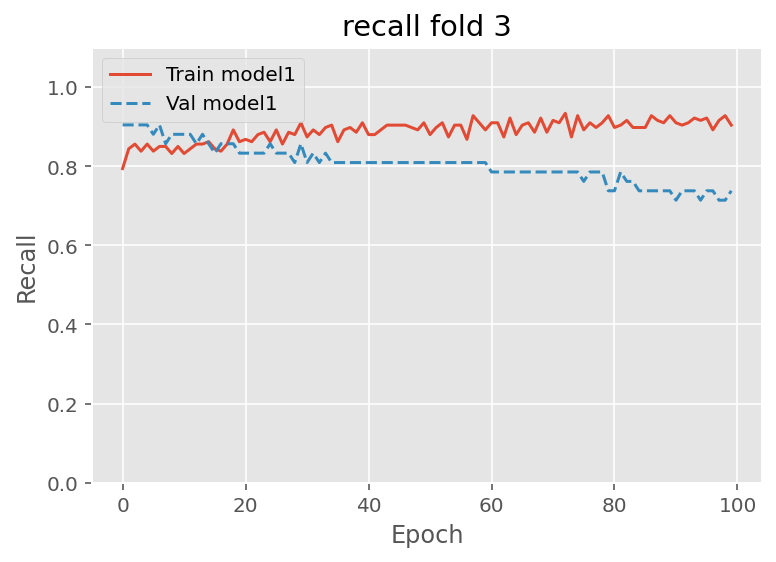

[[723 217]
 [ 11  31]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86       940
           1       0.12      0.74      0.21        42

    accuracy                           0.77       982
   macro avg       0.56      0.75      0.54       982
weighted avg       0.95      0.77      0.84       982



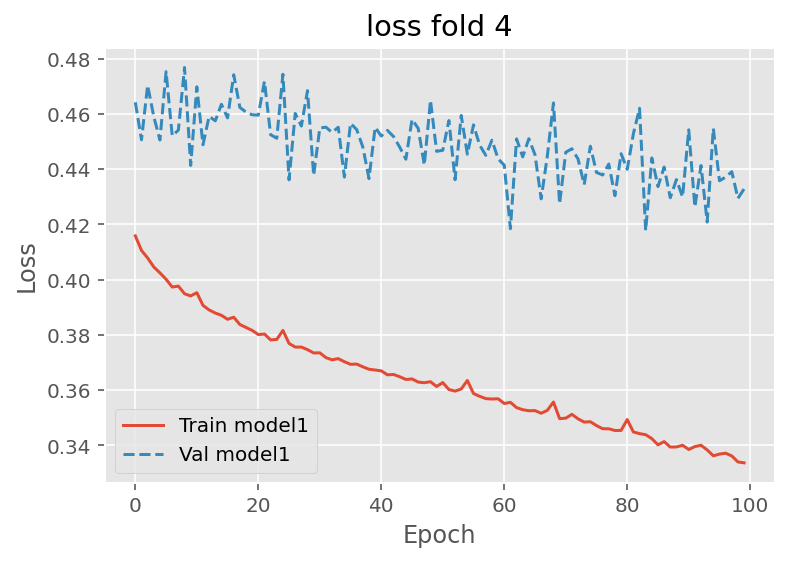

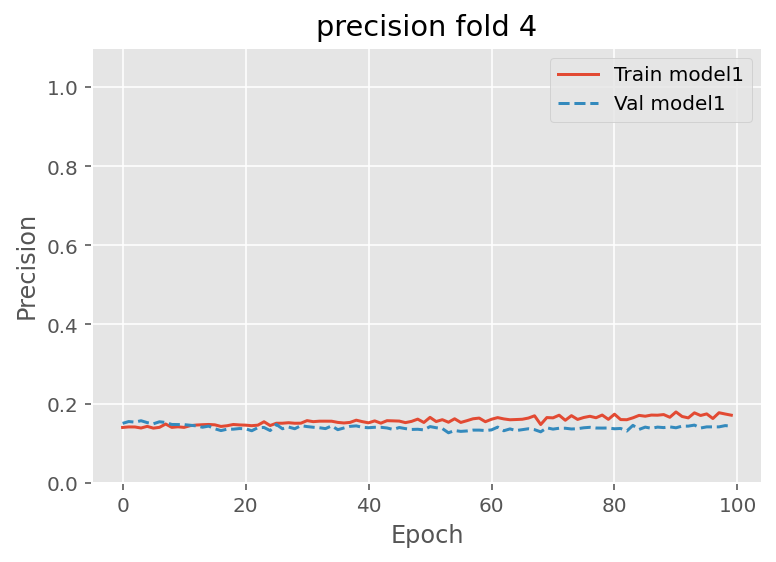

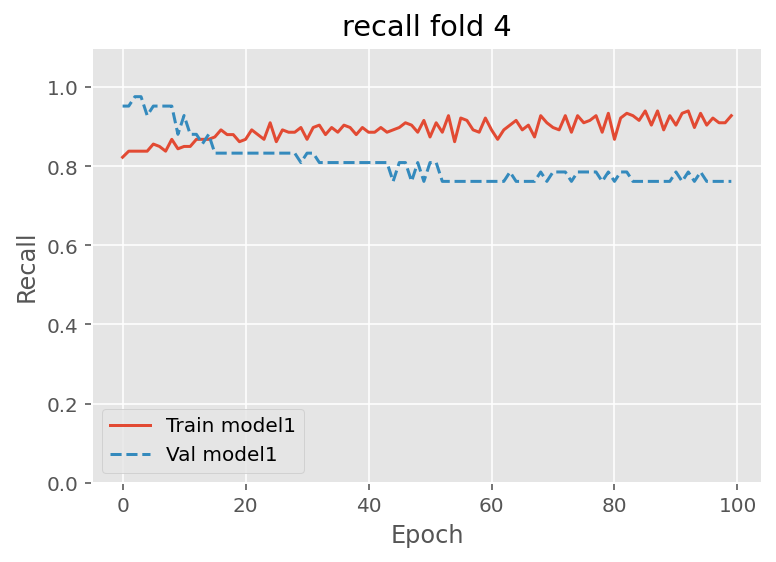

[[747 192]
 [ 10  32]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.88       939
           1       0.14      0.76      0.24        42

    accuracy                           0.79       981
   macro avg       0.56      0.78      0.56       981
weighted avg       0.95      0.79      0.85       981



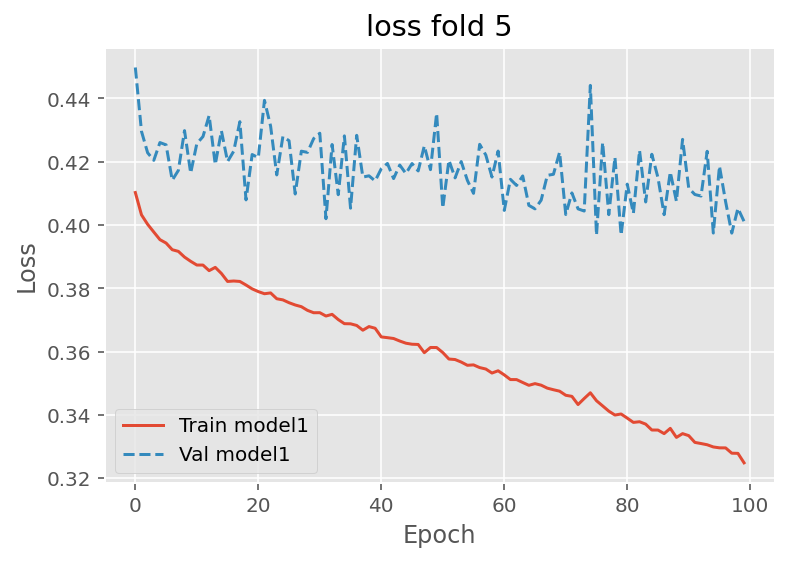

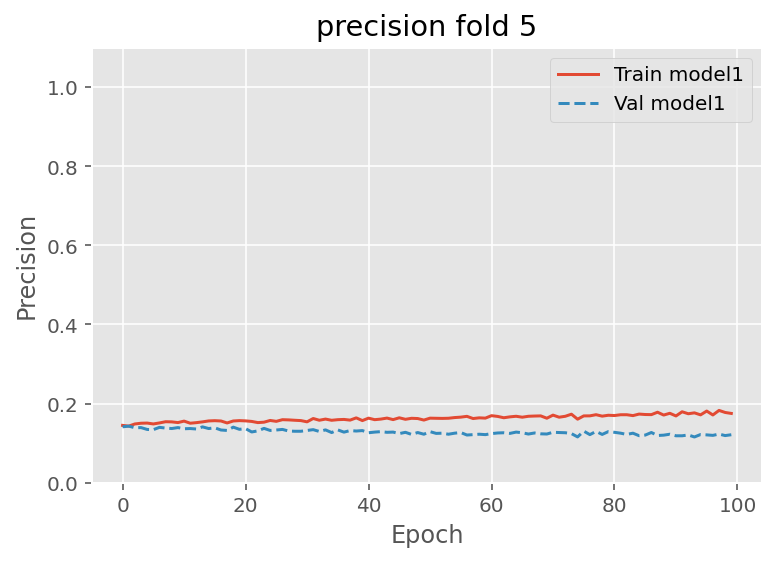

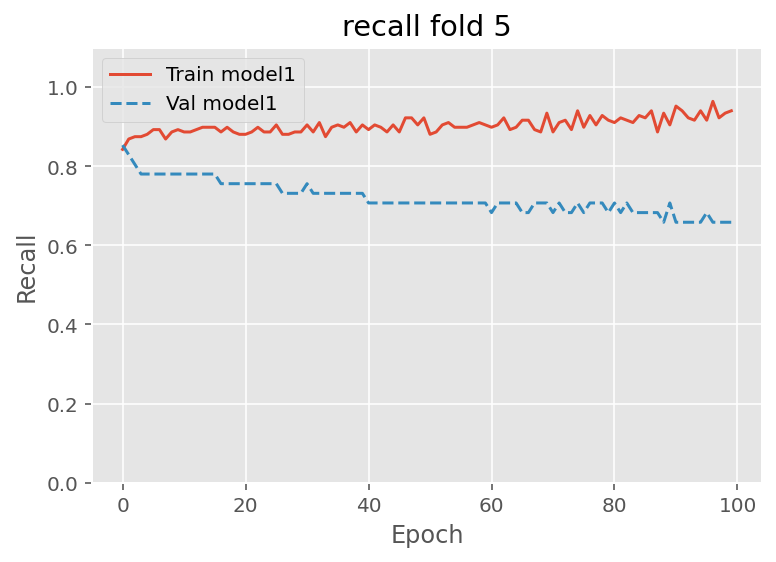

[[744 196]
 [ 14  27]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       940
           1       0.12      0.66      0.20        41

    accuracy                           0.79       981
   macro avg       0.55      0.73      0.54       981
weighted avg       0.95      0.79      0.85       981

model1: mean precision:0.13309679643809796 and standard deviation:0.004977526229827625
model1: mean recall:0.7775737482309342 and standard deviation:0.03266462108892026
model1: mean f1-score:0.22725360825418153 and standard deviation:0.008224496677260187
CPU times: user 1min 10s, sys: 7.13 s, total: 1min 17s
Wall time: 54.6 s


In [33]:
%%time
m1_eval = evaluate_model(make_model1,input_crossed,input_cat,input_num,final_branch,'model1')

### My model 2, combined embedding layer, wide layer(cross features are hypertension_heart_disease_diabetes_smoking_status and gender_work_type_ever_married_residence_type) and 3 deep layers

In [34]:
y = df['stroke'].to_numpy()

X_crossed = df[cross_col_df_names].to_numpy()
# save categorical features
X_cat = df[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_num =  df[numeric_headers].to_numpy()

# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                output_dim=int(np.sqrt(N)), 
                input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
# wide_branch = concatenate(crossed_outputs, name='wide_concat')
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                output_dim=int(np.sqrt(N)), 
                input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_num.shape[1],), name='numeric')
x_dense = Dense(units=6, activation='sigmoid',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=15,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

def make_model2(input_crossed,input_cat,input_num,final_branch):
    model = Model(inputs=[input_crossed,input_cat,input_num], 
                    outputs=final_branch)
    model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=score)
    return model

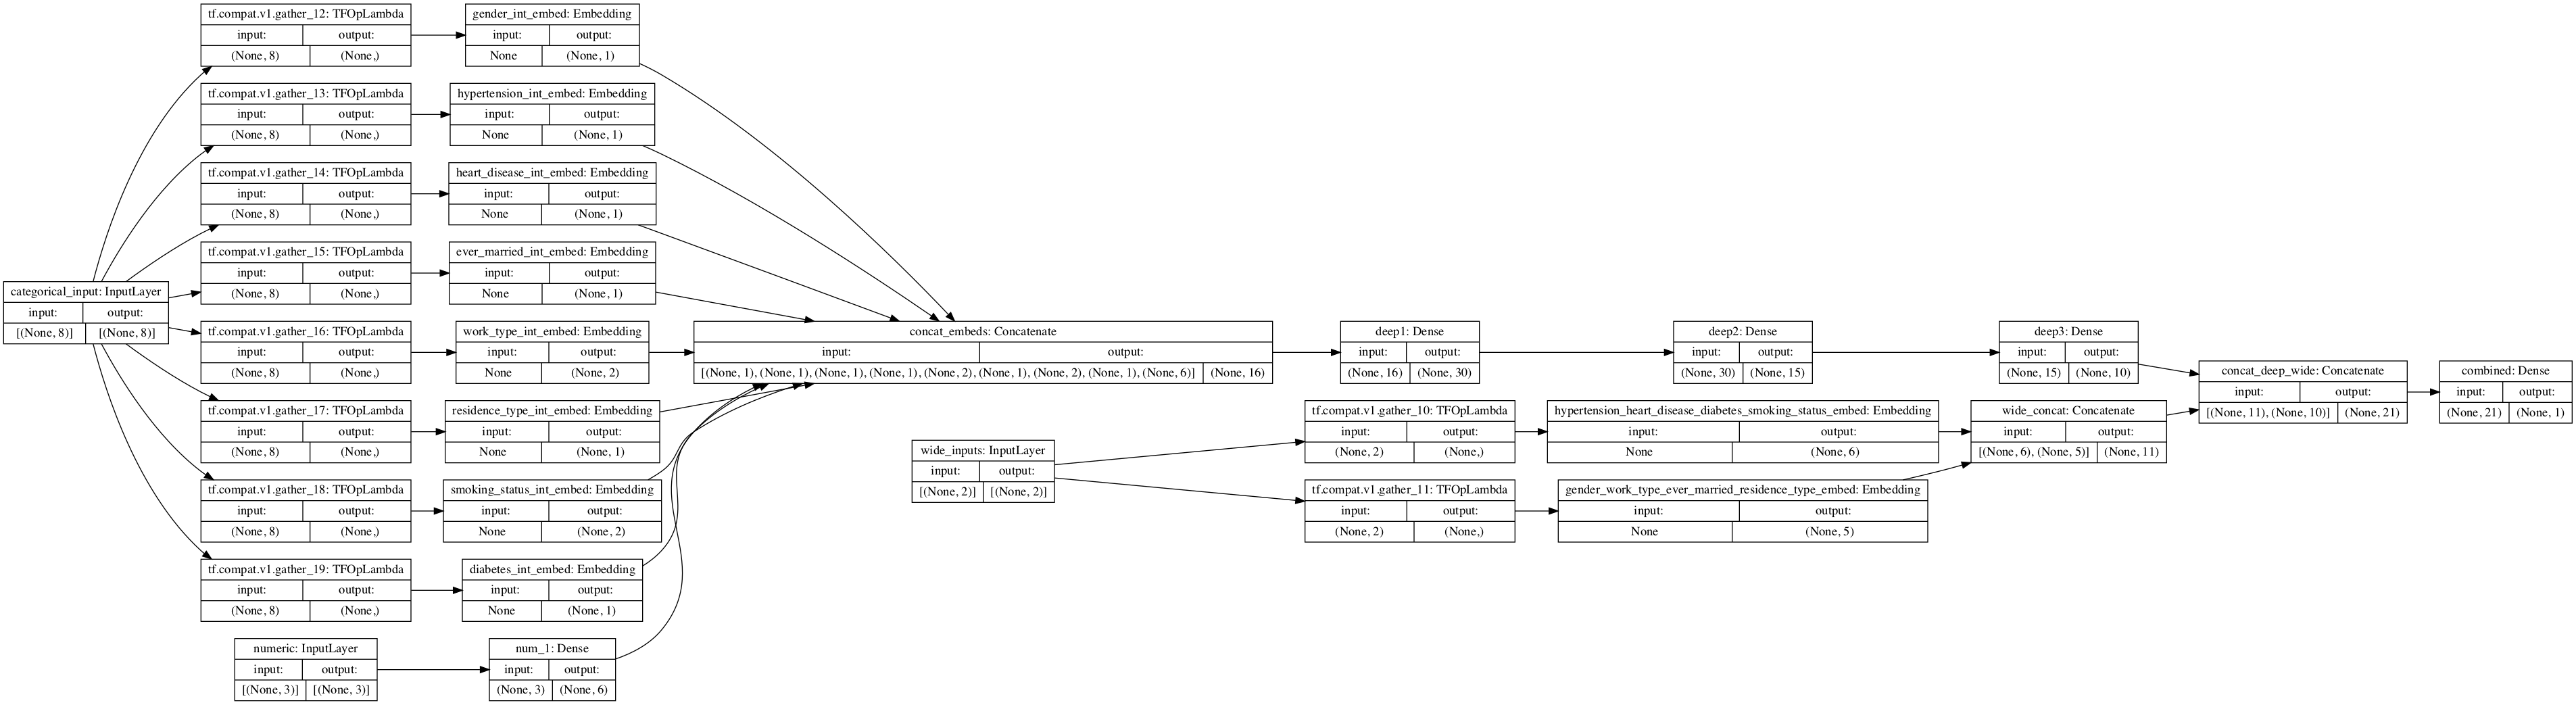

In [35]:
model2 = make_model2(input_crossed,input_cat,input_num,final_branch)
plot_model(
    model2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [36]:
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_input (InputLayer)  [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.compat.v1.gather_12 (TFOpLam (None,)              0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf.compat.v1.gather_13 (TFOpLam (None,)              0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf.compat.v1.gather_14 (TFOpLam (None,)              0           categorical_input[0][0]          
____________________________________________________________________________________________

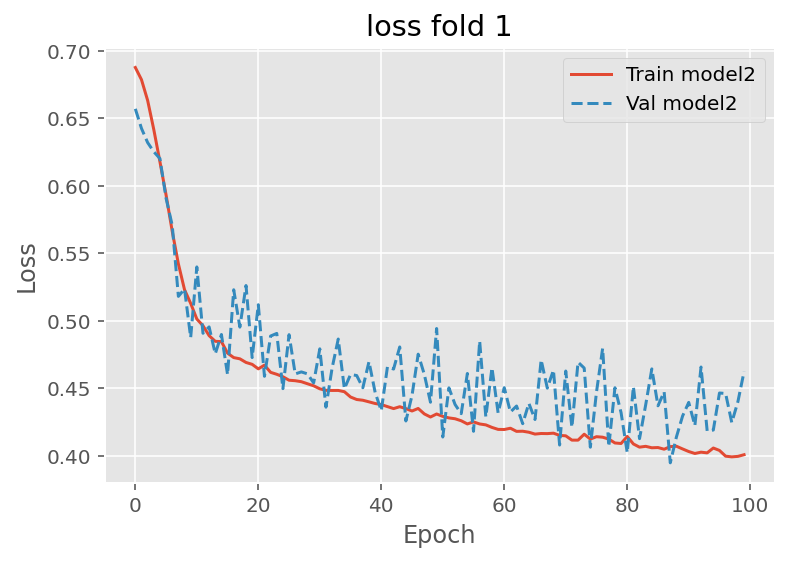

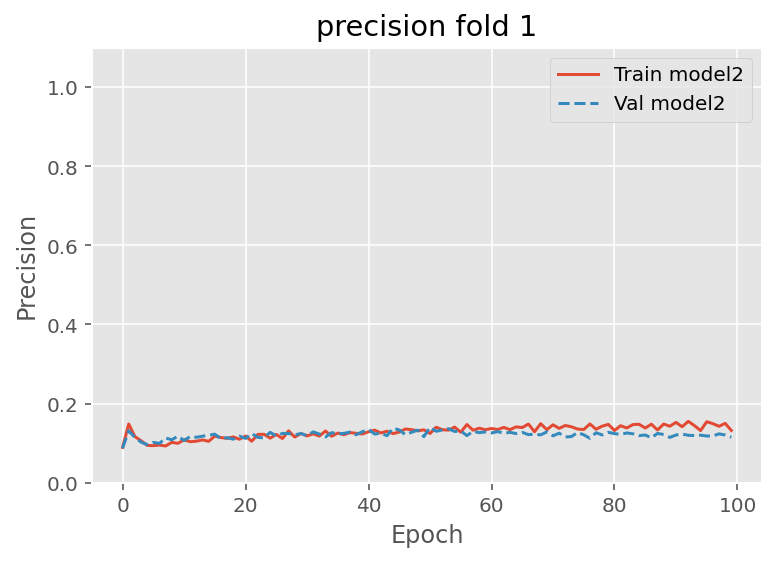

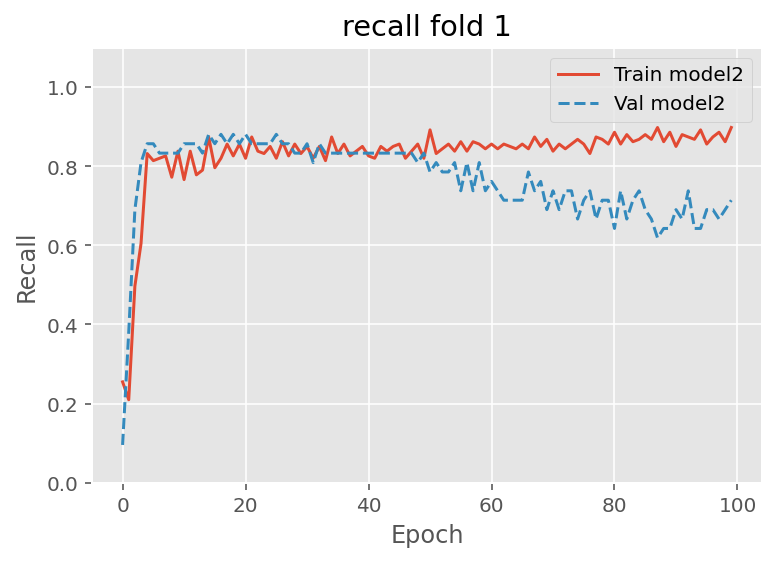

[[709 231]
 [ 12  30]]
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       940
           1       0.11      0.71      0.20        42

    accuracy                           0.75       982
   macro avg       0.55      0.73      0.53       982
weighted avg       0.95      0.75      0.83       982



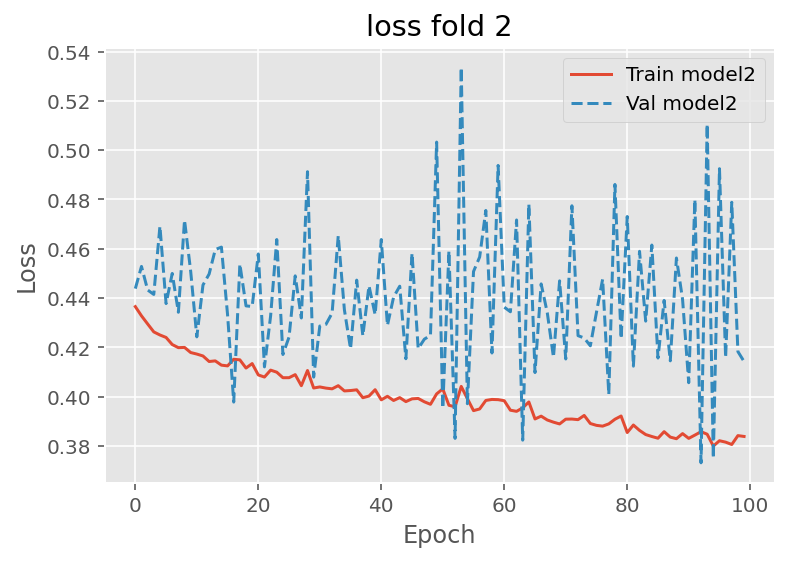

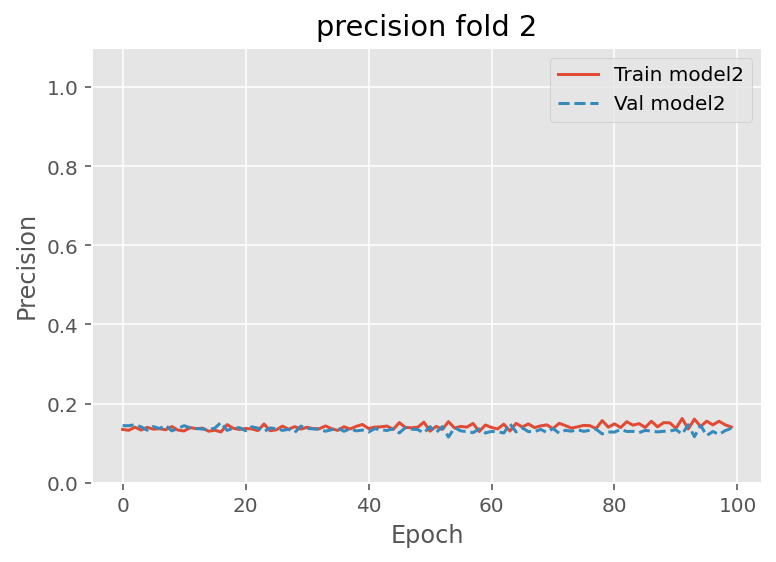

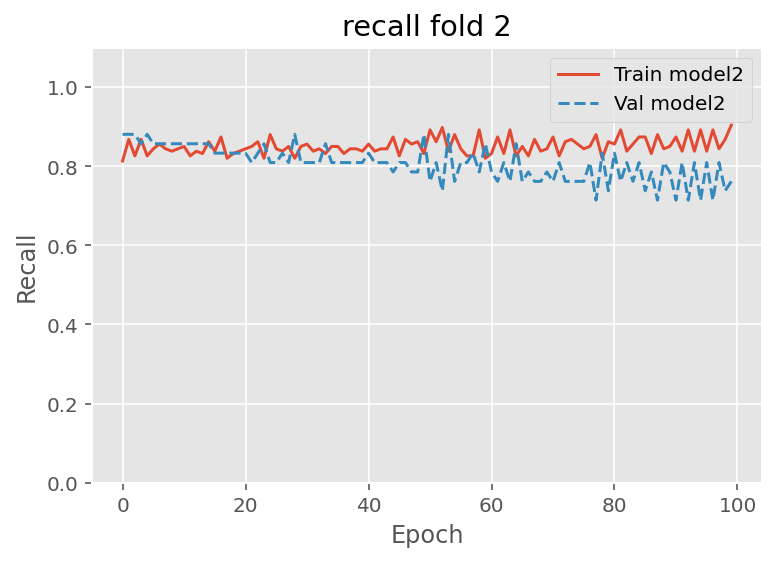

[[739 201]
 [ 10  32]]
              precision    recall  f1-score   support

           0       0.99      0.79      0.88       940
           1       0.14      0.76      0.23        42

    accuracy                           0.79       982
   macro avg       0.56      0.77      0.55       982
weighted avg       0.95      0.79      0.85       982



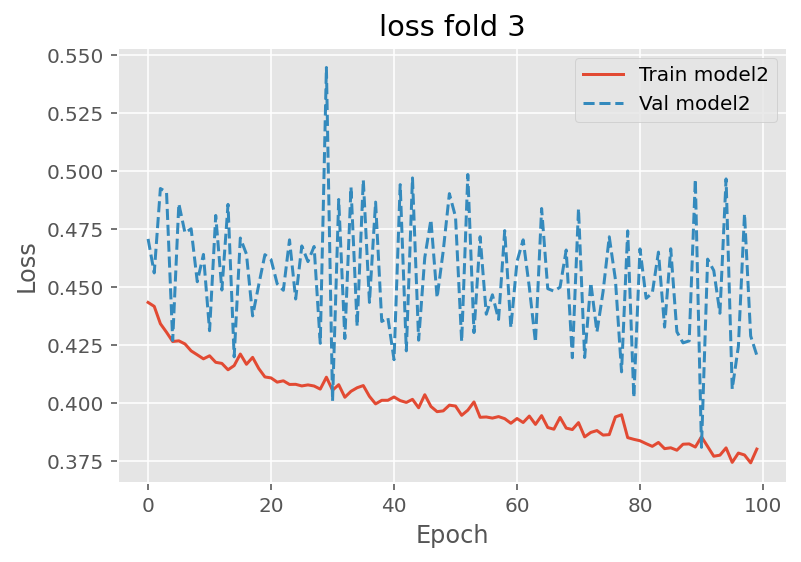

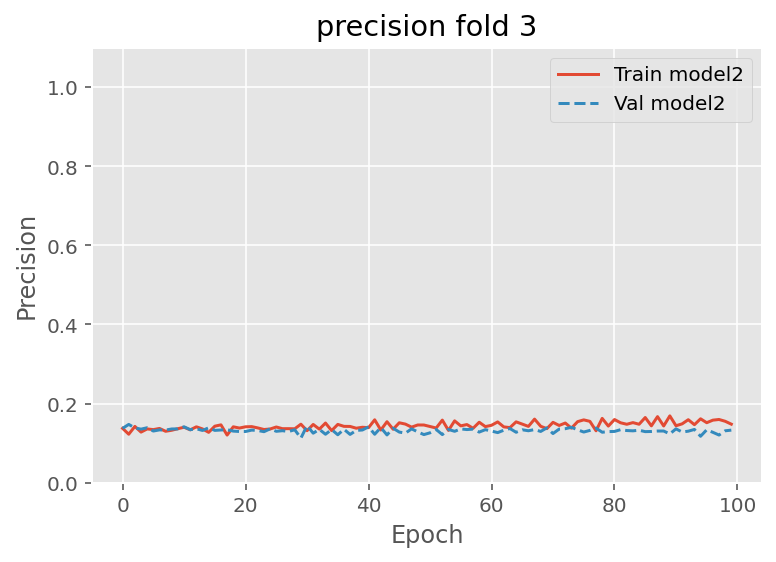

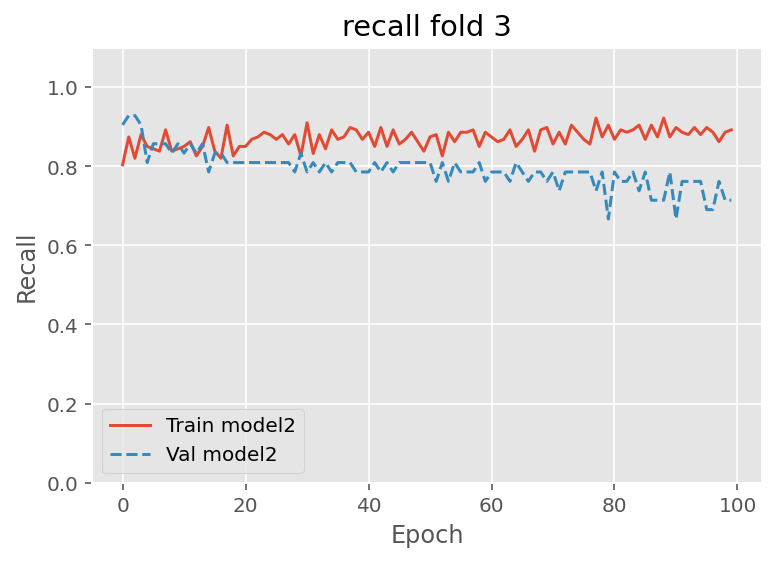

[[744 196]
 [ 12  30]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       940
           1       0.13      0.71      0.22        42

    accuracy                           0.79       982
   macro avg       0.56      0.75      0.55       982
weighted avg       0.95      0.79      0.85       982



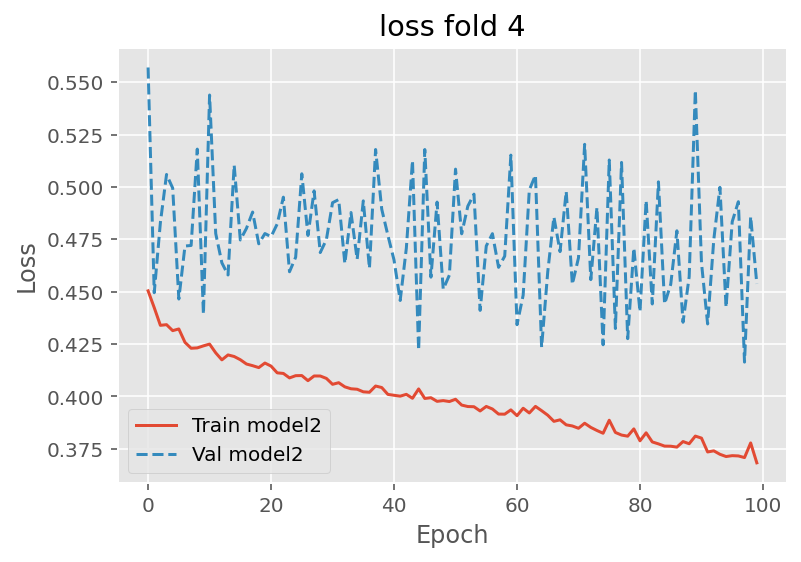

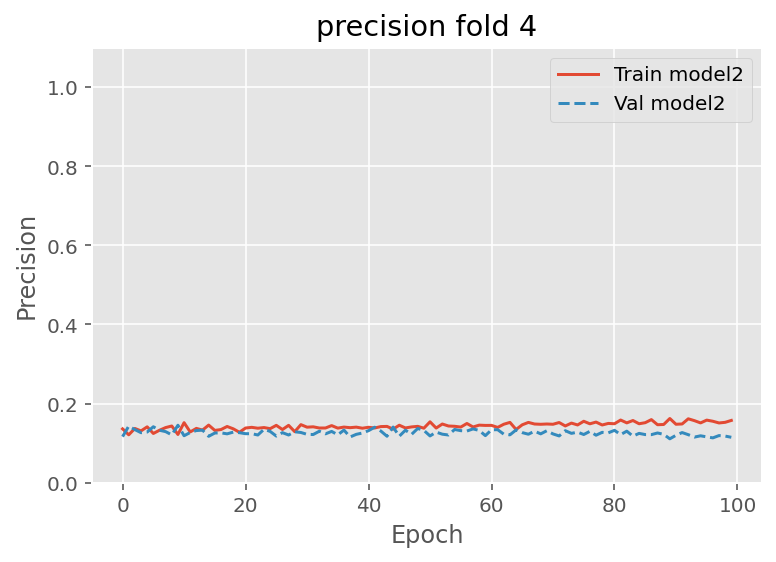

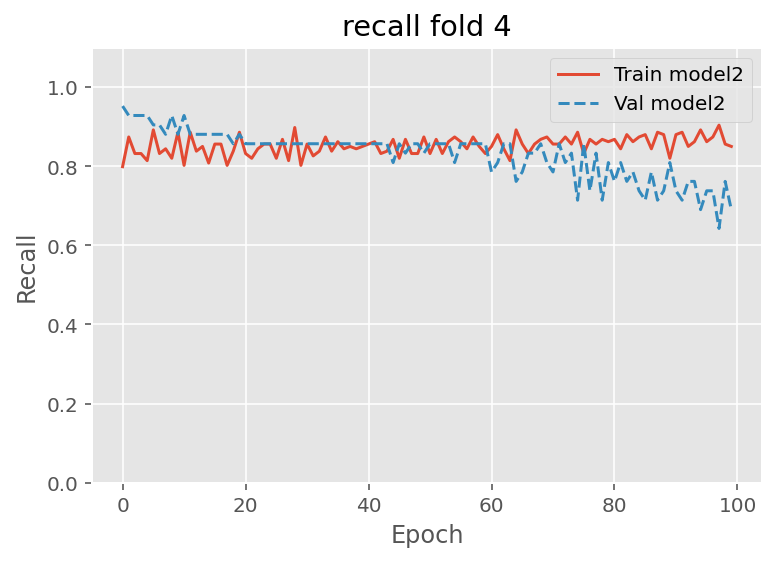

[[715 224]
 [ 13  29]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       939
           1       0.11      0.69      0.20        42

    accuracy                           0.76       981
   macro avg       0.55      0.73      0.53       981
weighted avg       0.95      0.76      0.83       981



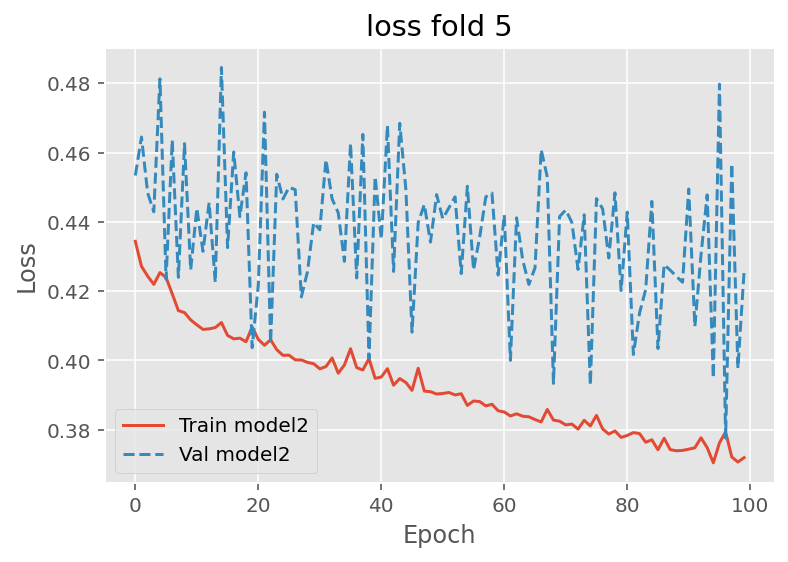

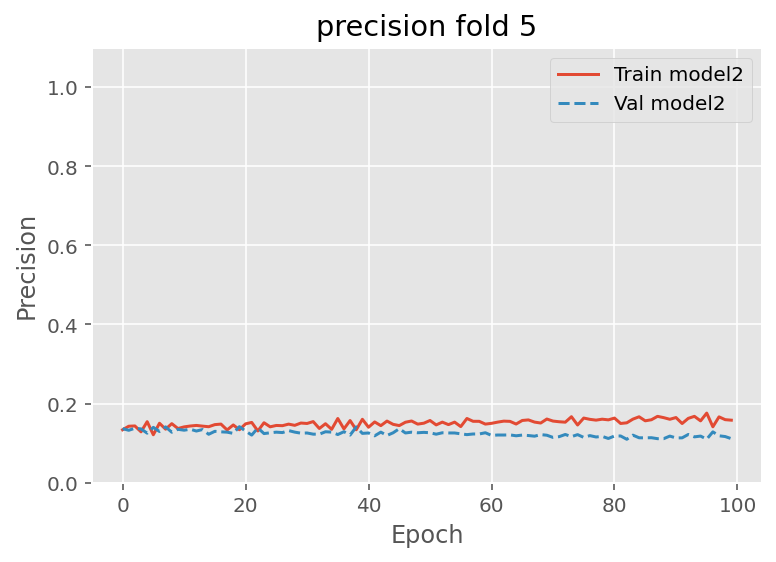

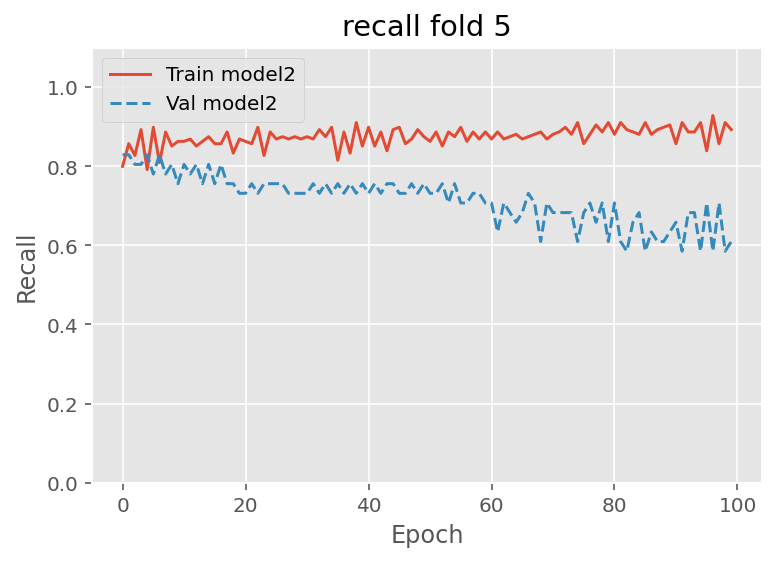

[[740 200]
 [ 16  25]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       940
           1       0.11      0.61      0.19        41

    accuracy                           0.78       981
   macro avg       0.54      0.70      0.53       981
weighted avg       0.94      0.78      0.84       981

model2: mean precision:0.12702564524114132 and standard deviation:0.004706470784177938
model2: mean recall:0.7828873396664858 and standard deviation:0.039205141395953894
model2: mean f1-score:0.2185309888386852 and standard deviation:0.007850817594239197
CPU times: user 1min 15s, sys: 8.55 s, total: 1min 23s
Wall time: 57.4 s


In [37]:
%%time
m2_eval = evaluate_model(make_model2,input_crossed,input_cat,input_num,final_branch,'model2')

In [38]:
initial_bias = np.log([pos/neg])
print(initial_bias)

[-3.11277075]


### My model 3, comparing to the model 2, there is a dropout layer in the deep network because it may make generalization better, and 5 deep layers. Besides, I would like to add an initial bias into the model to see if it could perform better.

In [39]:
y = df['stroke'].to_numpy()

X_crossed = df[cross_col_df_names].to_numpy()
# save categorical features
X_cat = df[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_num =  df[numeric_headers].to_numpy()

# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                output_dim=int(np.sqrt(N)), 
                input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
# wide_branch = concatenate(crossed_outputs, name='wide_concat')
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                output_dim=int(np.sqrt(N)), 
                input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_num.shape[1],), name='numeric')
x_dense = Dense(units=10, activation='sigmoid',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=200,activation='relu', name='deep1')(deep_branch)
deep_branch = Dropout(0.5)(deep_branch)
deep_branch = Dense(units=100,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep4')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep5')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',bias_initializer=keras.initializers.Constant(initial_bias),
                    name='combined')(final_branch)

def make_model3(input_crossed,input_cat,input_num,final_branch):
    model = Model(inputs=[input_crossed,input_cat,input_num], 
                    outputs=final_branch)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=score)
    return model

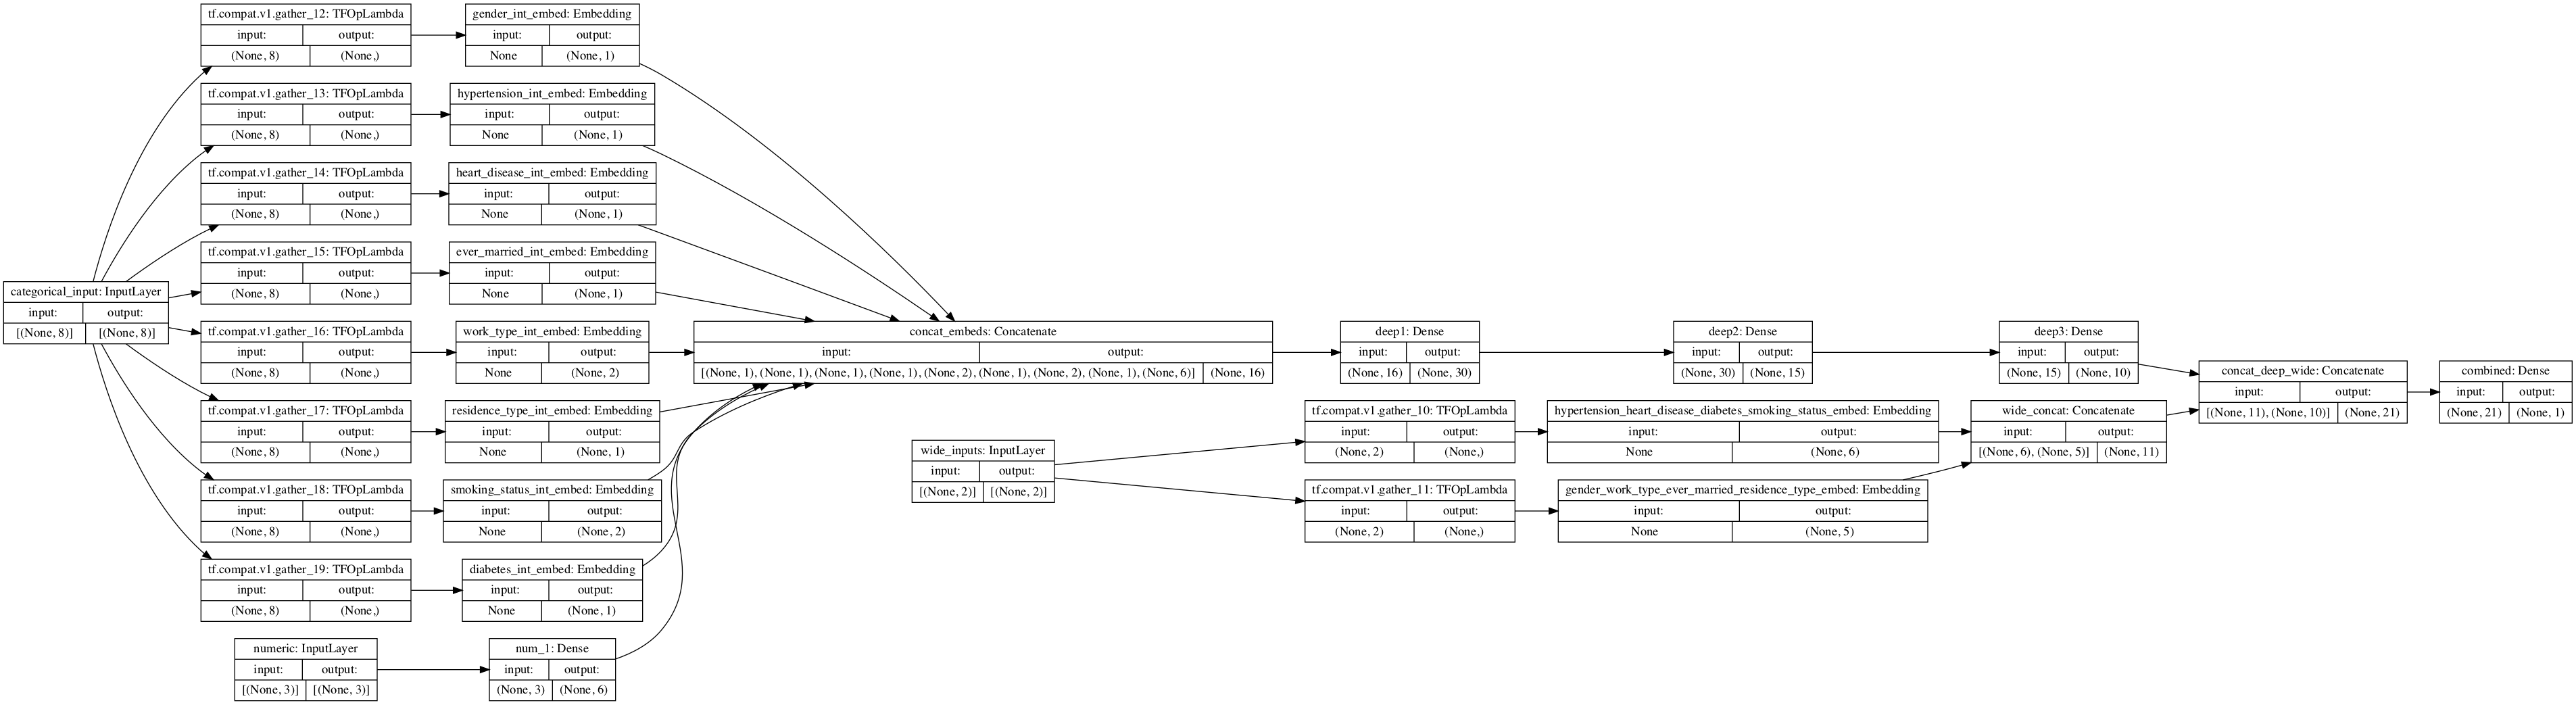

In [40]:
model3 = make_model3(input_crossed,input_cat,input_num,final_branch)
plot_model(
    model2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [41]:
model3.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_input (InputLayer)  [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.compat.v1.gather_22 (TFOpLam (None,)              0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf.compat.v1.gather_23 (TFOpLam (None,)              0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf.compat.v1.gather_24 (TFOpLam (None,)              0           categorical_input[0][0]          
___________________________________________________________________________________________

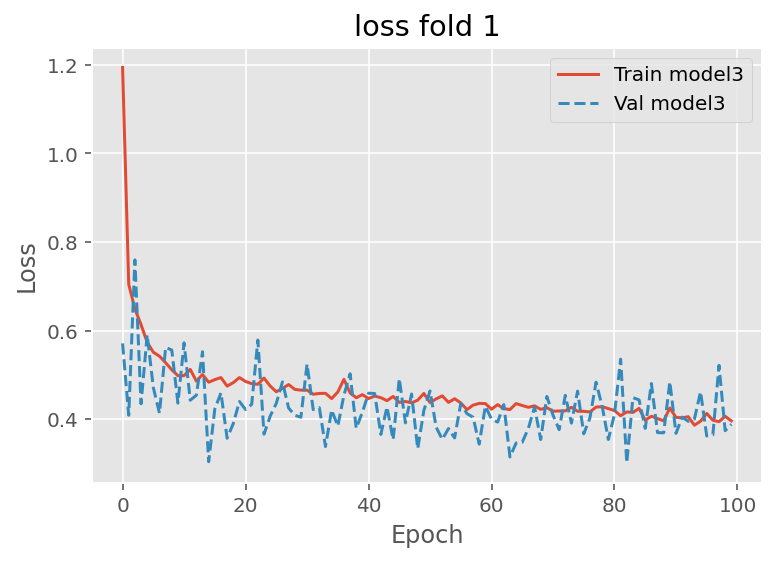

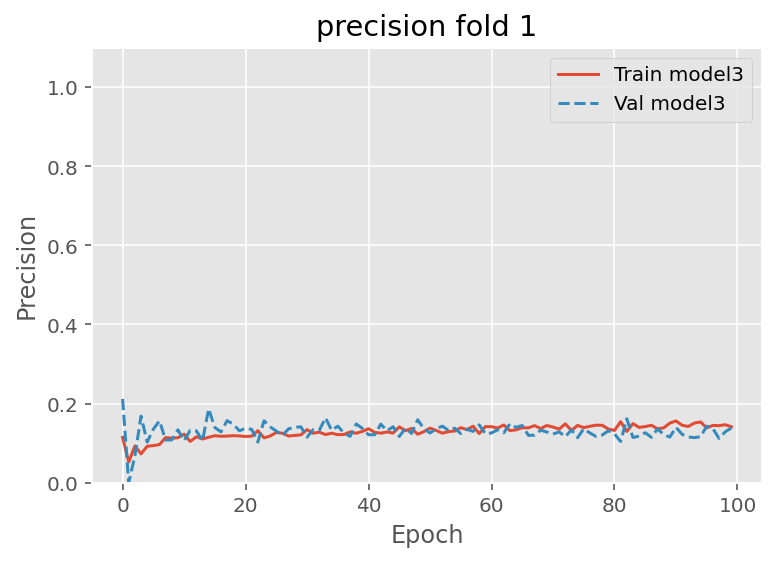

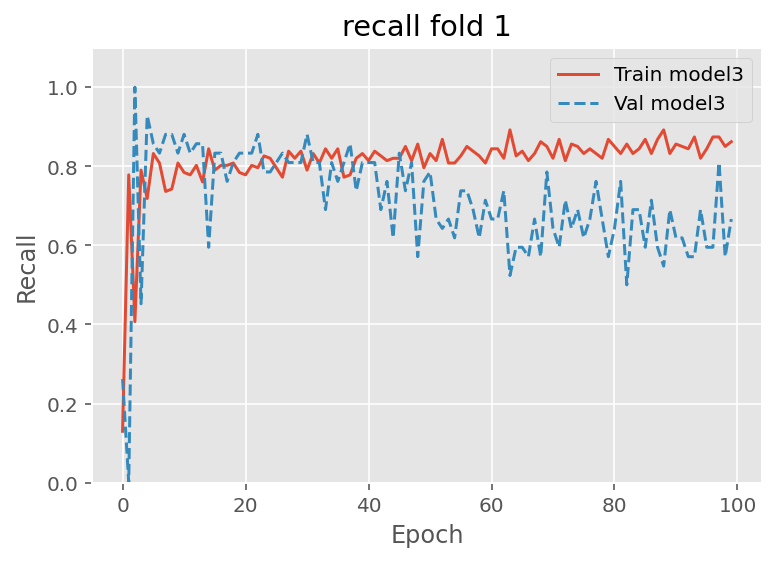

[[765 175]
 [ 14  28]]
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       940
           1       0.14      0.67      0.23        42

    accuracy                           0.81       982
   macro avg       0.56      0.74      0.56       982
weighted avg       0.95      0.81      0.86       982



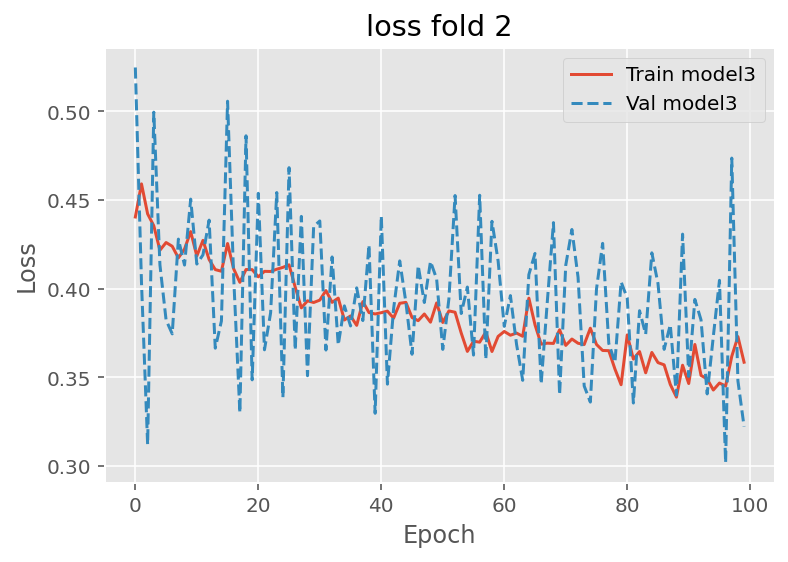

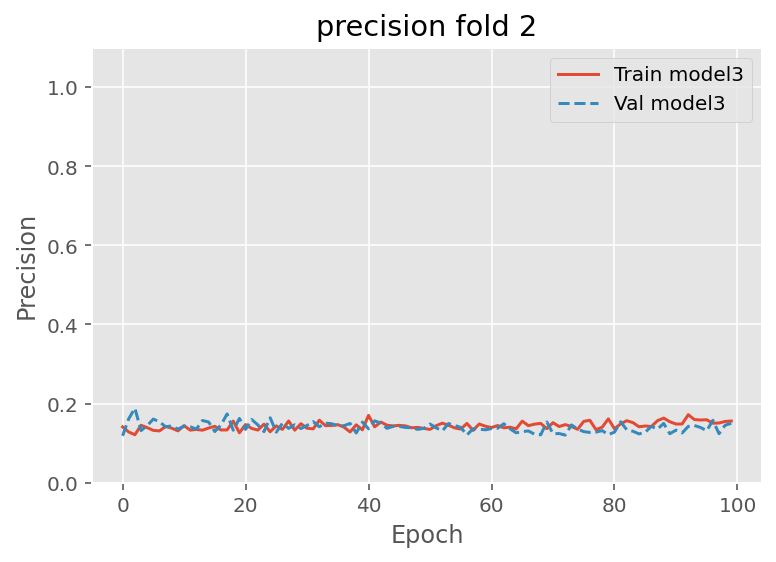

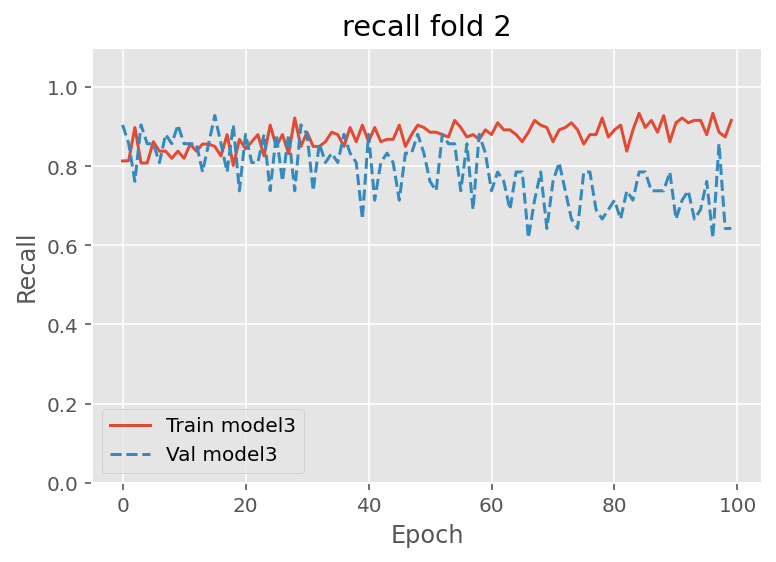

[[787 153]
 [ 15  27]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       940
           1       0.15      0.64      0.24        42

    accuracy                           0.83       982
   macro avg       0.57      0.74      0.57       982
weighted avg       0.95      0.83      0.88       982



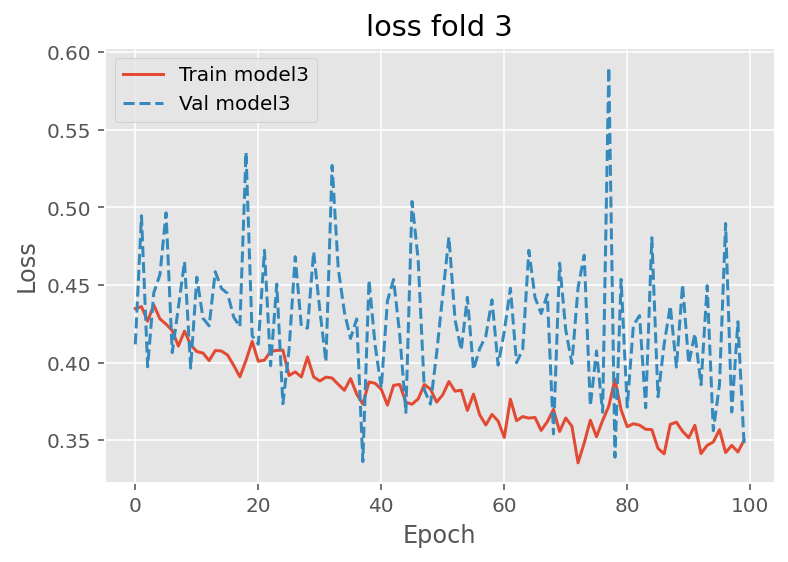

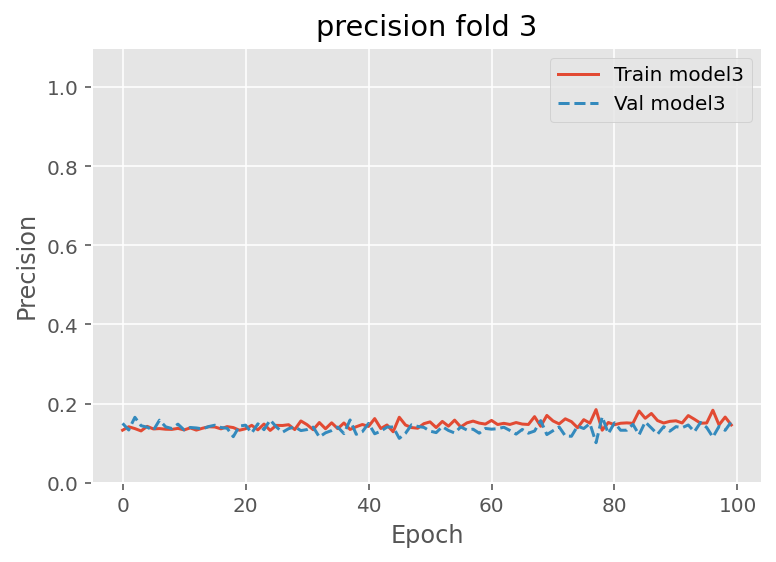

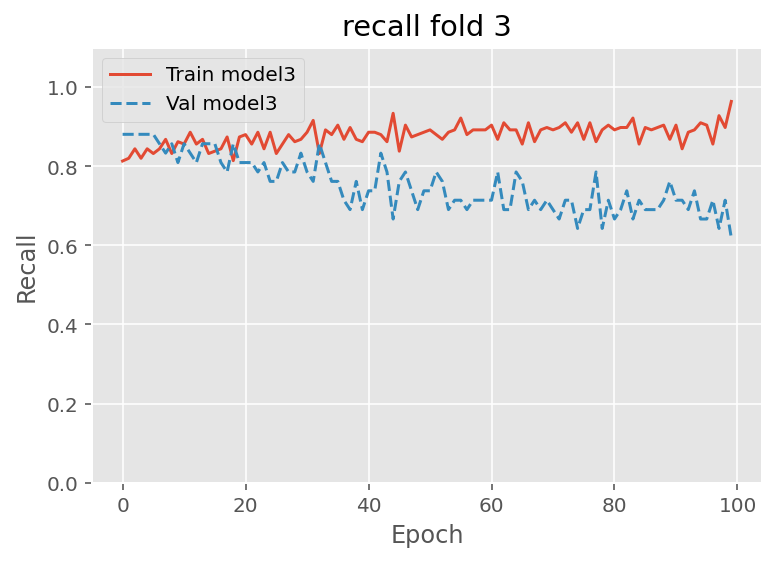

[[797 143]
 [ 16  26]]
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       940
           1       0.15      0.62      0.25        42

    accuracy                           0.84       982
   macro avg       0.57      0.73      0.58       982
weighted avg       0.94      0.84      0.88       982



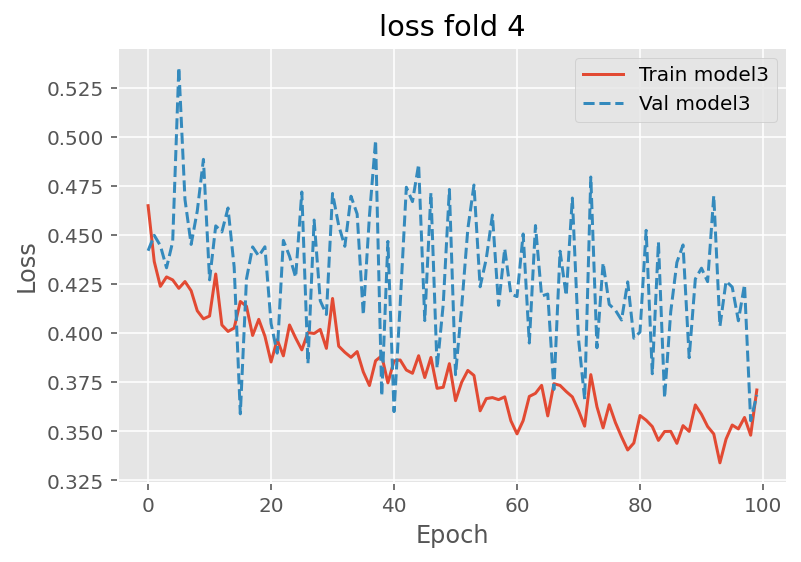

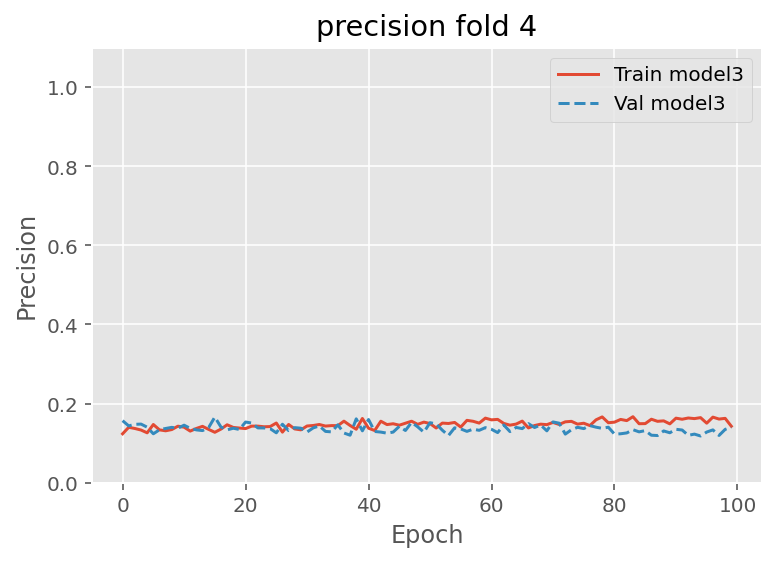

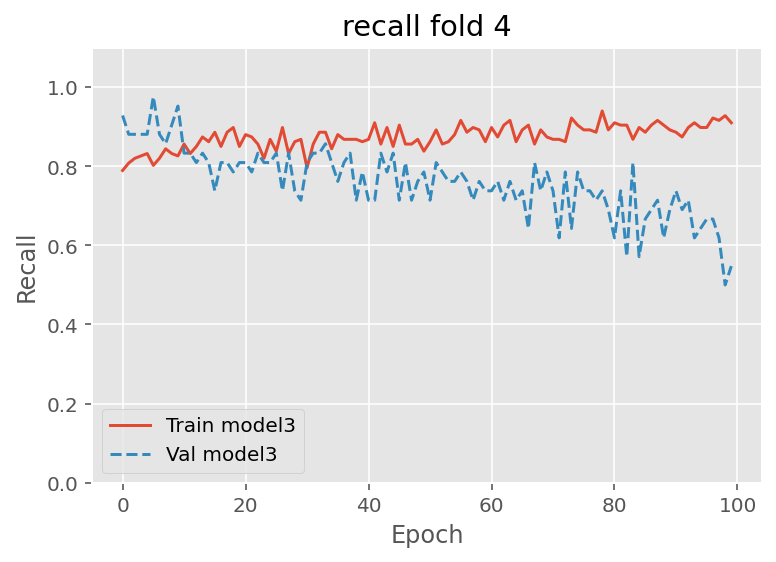

[[798 141]
 [ 19  23]]
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       939
           1       0.14      0.55      0.22        42

    accuracy                           0.84       981
   macro avg       0.56      0.70      0.57       981
weighted avg       0.94      0.84      0.88       981



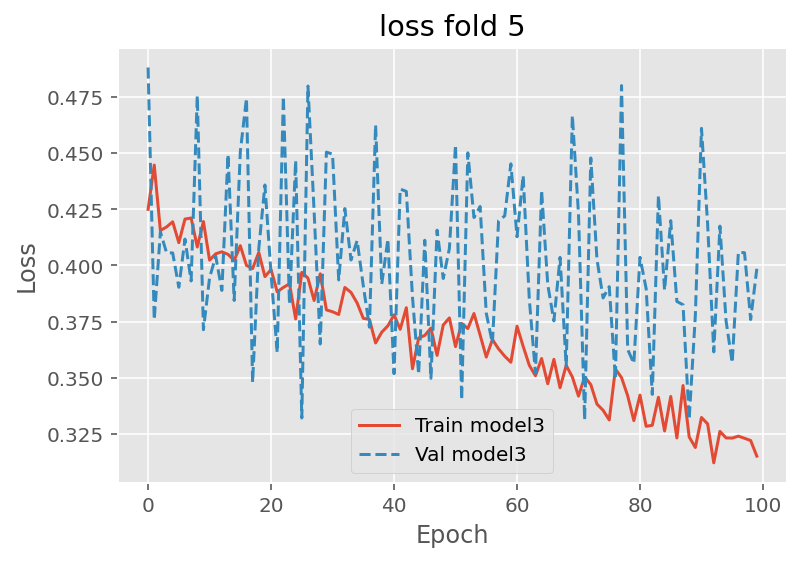

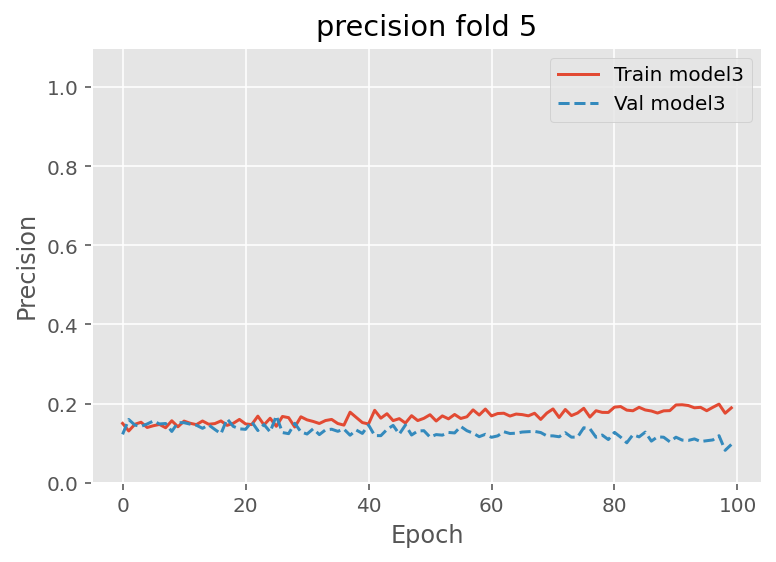

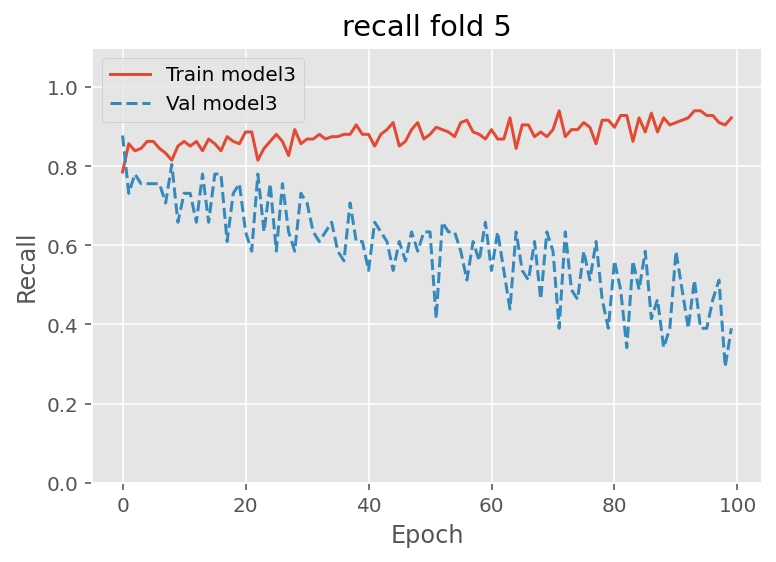

[[790 150]
 [ 25  16]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       940
           1       0.10      0.39      0.15        41

    accuracy                           0.82       981
   macro avg       0.53      0.62      0.53       981
weighted avg       0.93      0.82      0.87       981

model3: mean precision:0.13391782350838186 and standard deviation:0.004519509653171002
model3: mean recall:0.721067363023758 and standard deviation:0.0678161952902465
model3: mean f1-score:0.2257392009860096 and standard deviation:0.009699469748257143
CPU times: user 1min 35s, sys: 13.7 s, total: 1min 49s
Wall time: 1min 3s


In [42]:
%%time
m3_eval = evaluate_model(make_model3,input_crossed,input_cat,input_num,final_branch,'model3')

### Based on the ROC curve, model 1 is better than model 2.

In [43]:
t = 2.26/np.sqrt(10)
e = (1-m1_eval['f1']) - (1-m2_eval['f1'])
print(
    'The different between model2 and model1 is {},{}'.format(np.mean(e)-t*np.std(e),np.mean(e)+t*np.std(e))
)

The different between model2 and model1 is -0.012801679871988611,-0.004643558959004082


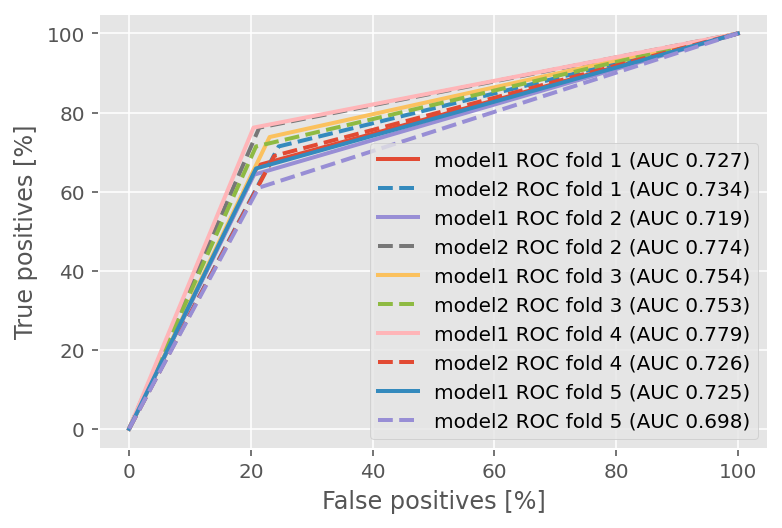

In [44]:
plot_roc(m1_eval,m2_eval,'model1','model2')

### Model 2 is better than model 3.

In [45]:
t = 2.26/np.sqrt(10)
e = (1-m2_eval['f1']) - (1-m3_eval['f1'])
print(
    'The different between model2 and model3 is {},{}'.format(np.mean(e)-t*np.std(e),np.mean(e)+t*np.std(e))
)

The different between model2 and model3 is 0.003942663920486427,0.01047376037416244


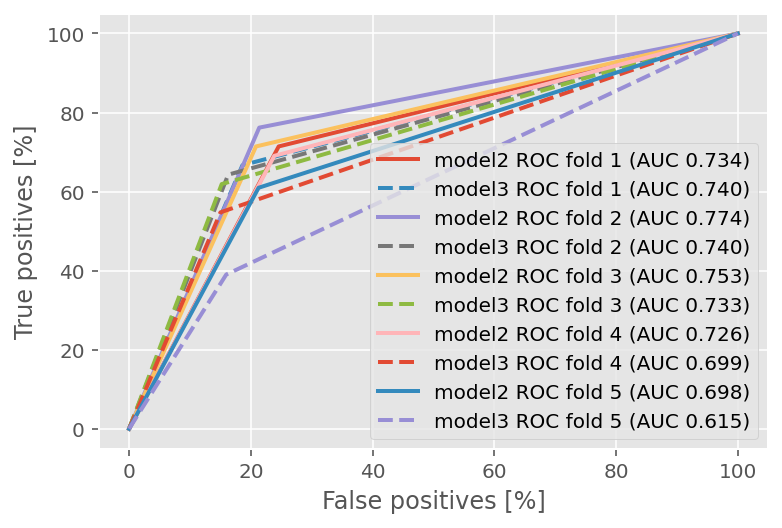

In [46]:
plot_roc(m2_eval,m3_eval,'model2','model3')

### Model 1 is better than model 3.

In [47]:
t = 2.26/np.sqrt(10)
e = (1-m1_eval['f1']) - (1-m3_eval['f1'])
print(
    'The different between model1 and model3 is {},{}'.format(np.mean(e)-t*np.std(e),np.mean(e)+t*np.std(e))
)

The different between model1 and model3 is -0.005380216746192265,0.002351402209848438


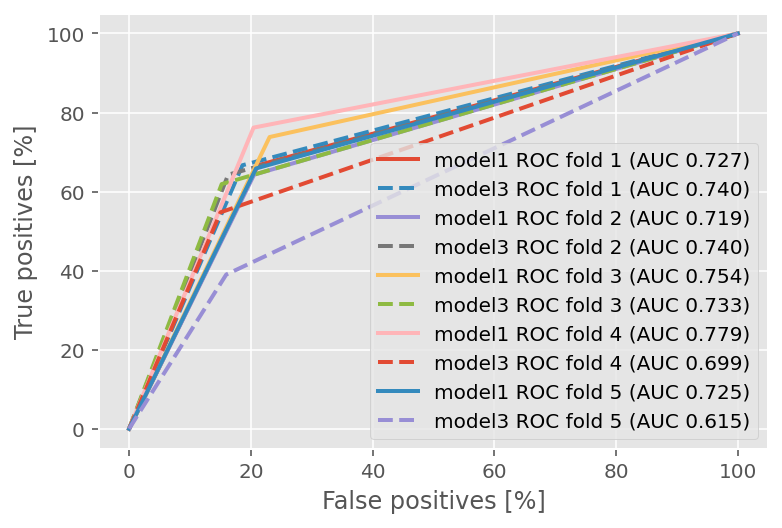

In [48]:
plot_roc(m1_eval,m3_eval,'model1','model3')

### 2.3 Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations. Use proper statistical method to compare the performance of different models.

In [49]:
X = df[feature_columns].to_numpy()
y = df['stroke'].to_numpy()

input_tensor = Input(shape=(X.shape[1],))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=60, activation='relu')(input_tensor)
x = Dense(units=30, activation='relu')(x)
x = Dense(units=15, activation='relu')(x)
predictions = Dense(1, activation='sigmoid',bias_initializer=keras.initializers.Constant(initial_bias))(x)

# This creates a model that includes
# the Input layer and three Dense layers

def make_model4(input_tensor,predictions):
    model = Model(inputs=input_tensor, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=score)
    return model

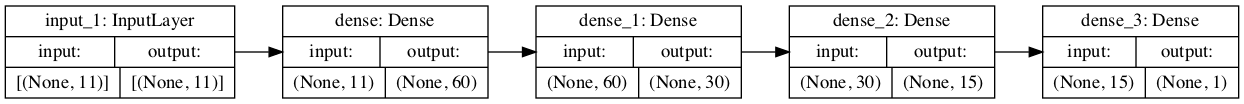

In [50]:
model4 = make_model4(input_tensor,predictions)
plot_model(
    model4, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [51]:
def evaluate_mlp_model(make_model,input_tensor,predictions,model_name,epochs=100):
    history_arr = []
    cvscore = []
    rocscore = []
    f1_s = lambda x,y: 2*x*y/(x+y)
    i = 0
    for train_index,test_index in cv.split(X,y):
        i += 1
        model = make_model(input_tensor,predictions)
        # neg,pos = np.bincount(y[train_index])
        h = model.fit(X[train_index],
            y[train_index], 
            epochs=epochs, 
            batch_size=512, 
            verbose=0,
            class_weight = class_weight,
            validation_data = (X[test_index],y[test_index]))
        history_arr.append(h)
        plot_metrics(h,model_name,i)
        # now lets see how well the model performed
        yhat = np.round(model.predict(X[test_index]))
        fp,tp,_ = mt.roc_curve(y[test_index],yhat)
        cvscore.append(
            [np.mean(h.history['val_precision']),np.mean(h.history['val_recall'])]
        )
        rocscore.append([tp,fp])
        print(mt.confusion_matrix(y[test_index],yhat))
        print(mt.classification_report(y[test_index],yhat))

    cvscore = np.array(cvscore)
    rocscore = np.array(rocscore)
    f1_measure = f1_s(cvscore[:,0],cvscore[:,1])
    print('{0}: mean precision:{1} and standard deviation:{2}'.format(model_name,np.mean(cvscore[:,0]),np.std(cvscore[:,0])))
    print('{0}: mean recall:{1} and standard deviation:{2}'.format(model_name,np.mean(cvscore[:,1]),np.std(cvscore[:,1])))
    print('{0}: mean f1-score:{1} and standard deviation:{2}'.format(model_name,np.mean(f1_measure),np.std(f1_measure)))
    return {'cv':cvscore,'roc':rocscore,'f1':f1_measure}

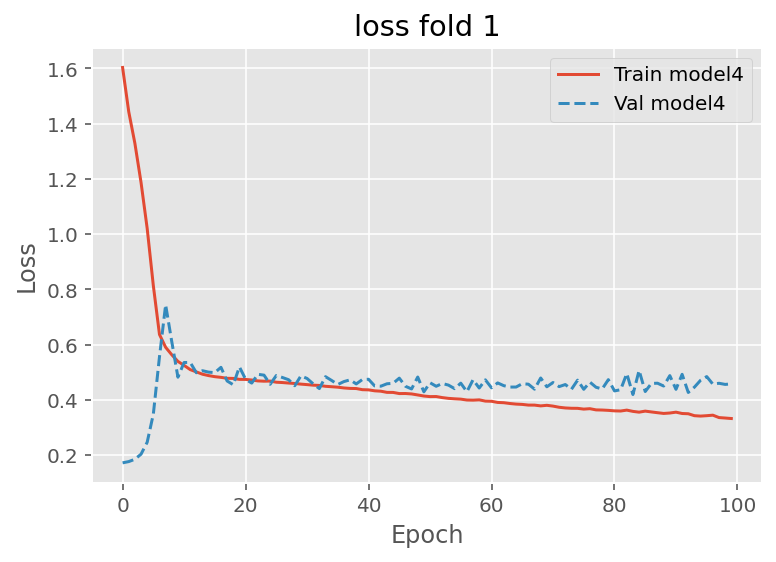

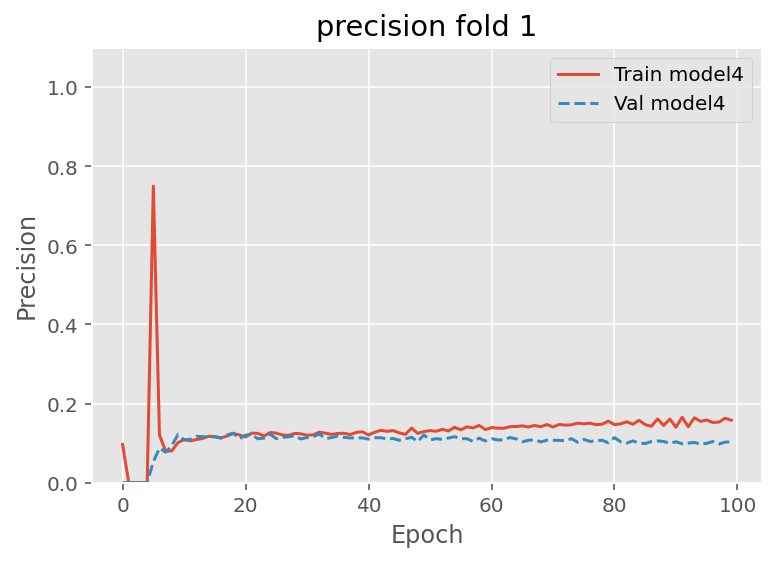

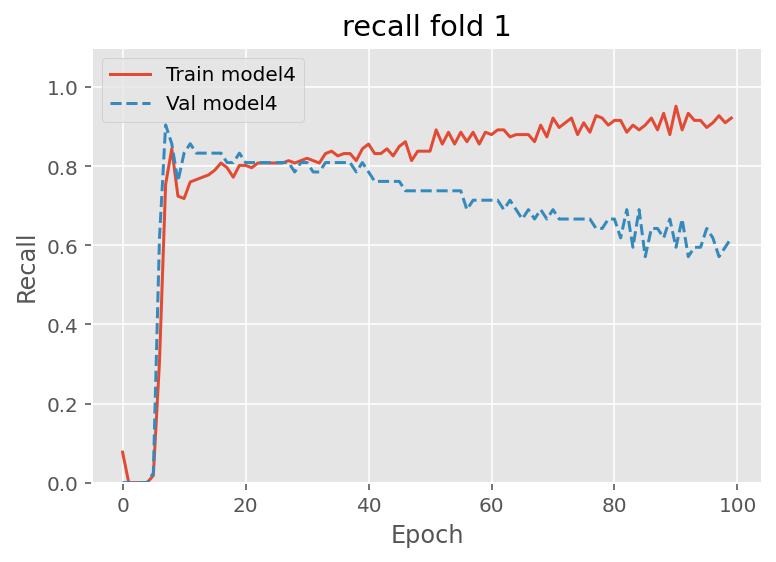

[[714 226]
 [ 16  26]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       940
           1       0.10      0.62      0.18        42

    accuracy                           0.75       982
   macro avg       0.54      0.69      0.52       982
weighted avg       0.94      0.75      0.83       982



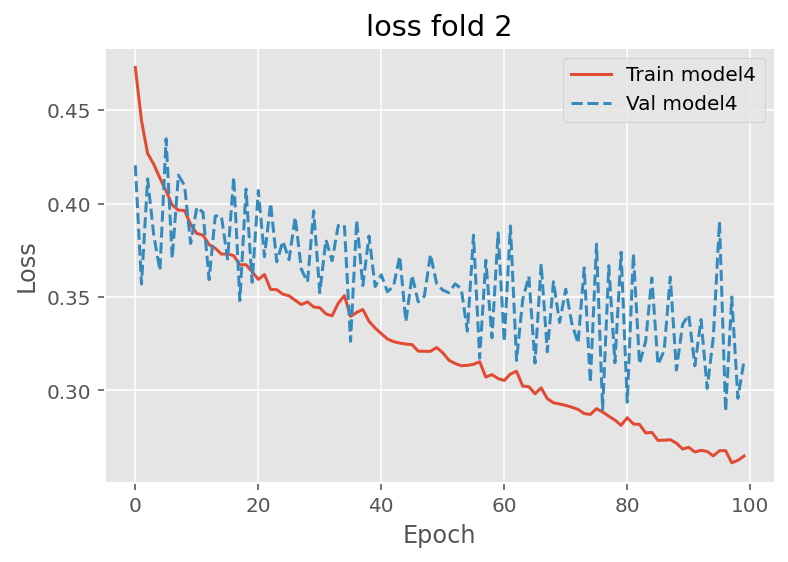

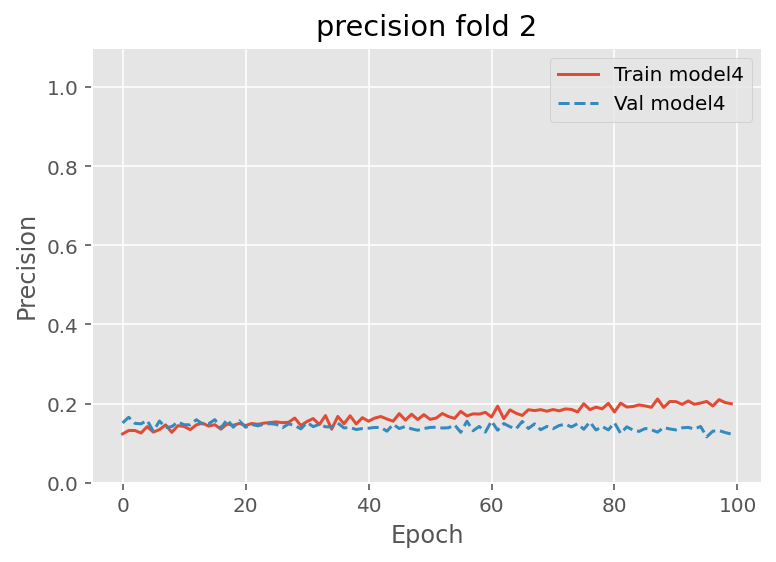

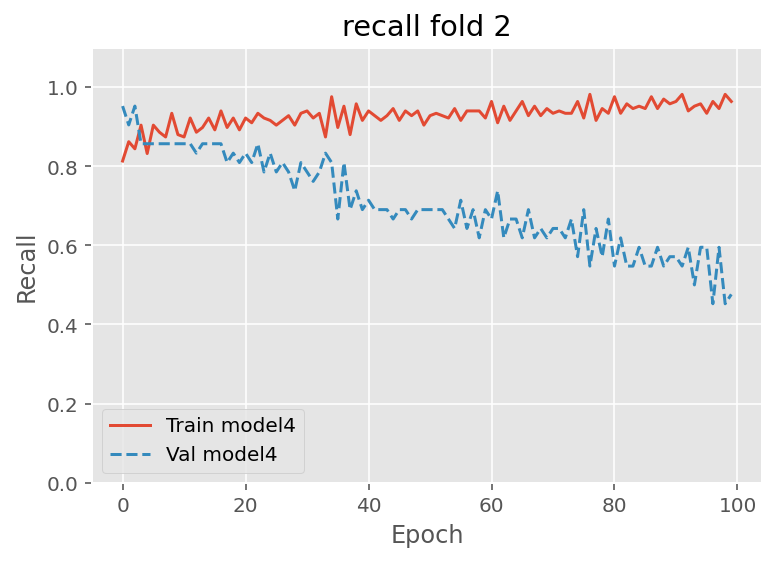

[[797 143]
 [ 22  20]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       940
           1       0.12      0.48      0.20        42

    accuracy                           0.83       982
   macro avg       0.55      0.66      0.55       982
weighted avg       0.94      0.83      0.88       982



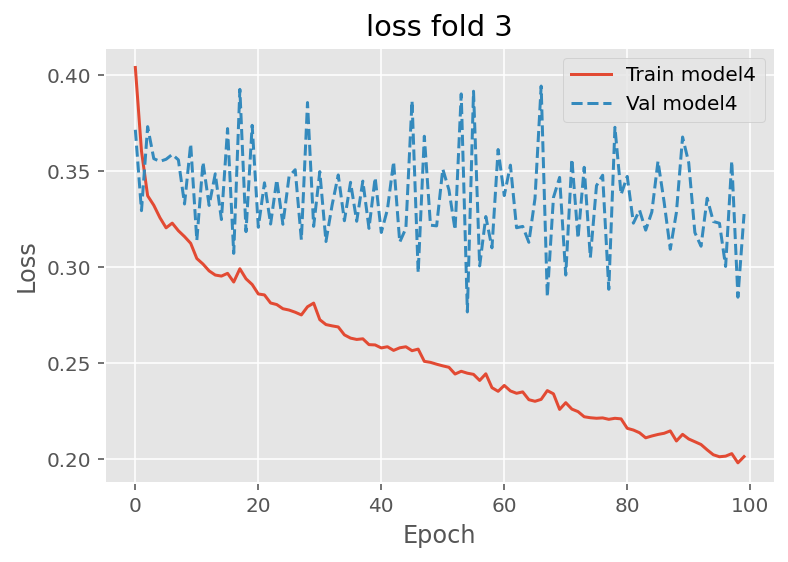

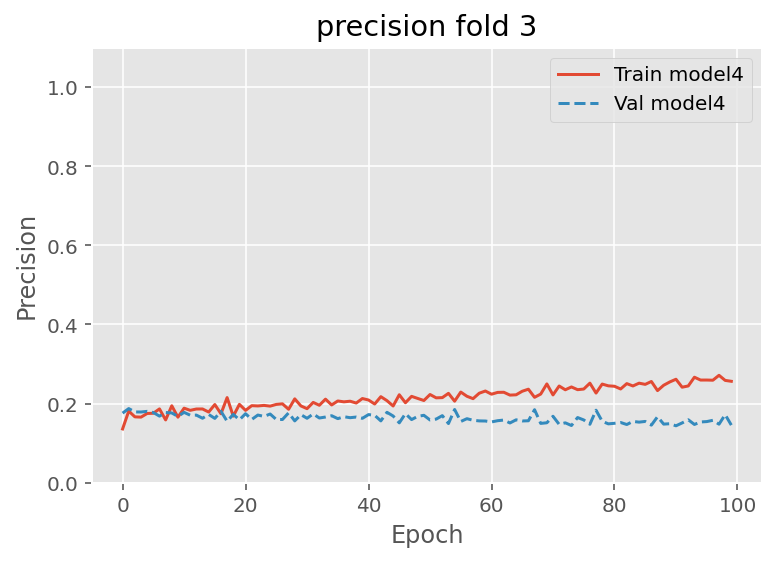

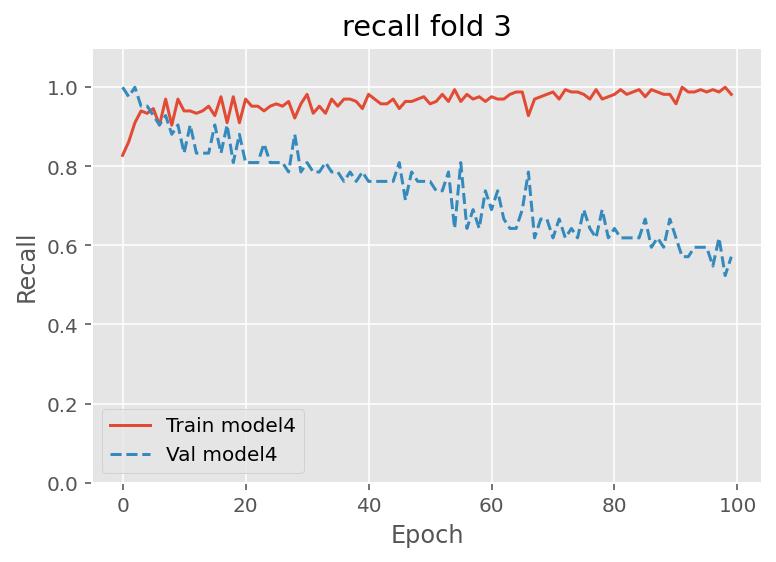

[[799 141]
 [ 18  24]]
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       940
           1       0.15      0.57      0.23        42

    accuracy                           0.84       982
   macro avg       0.56      0.71      0.57       982
weighted avg       0.94      0.84      0.88       982



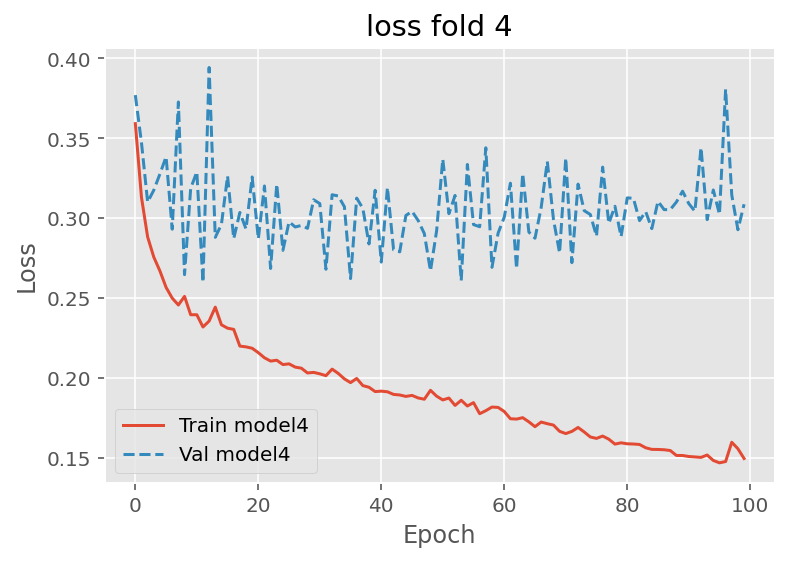

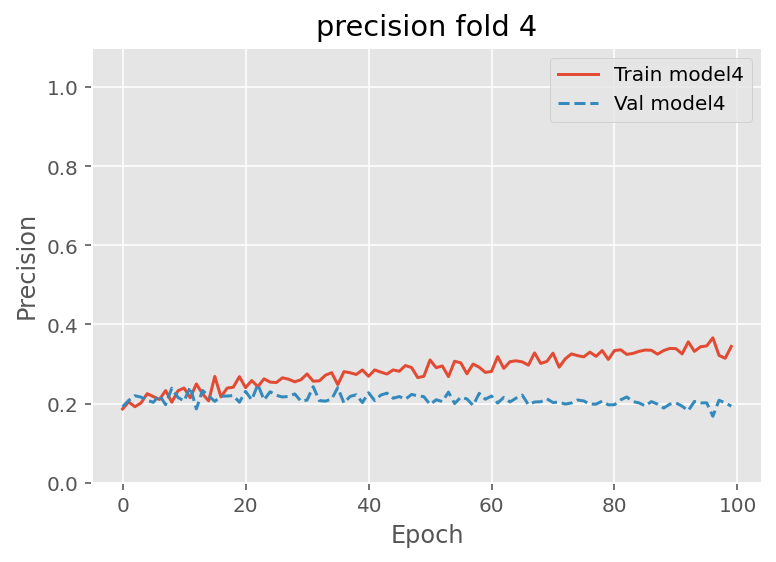

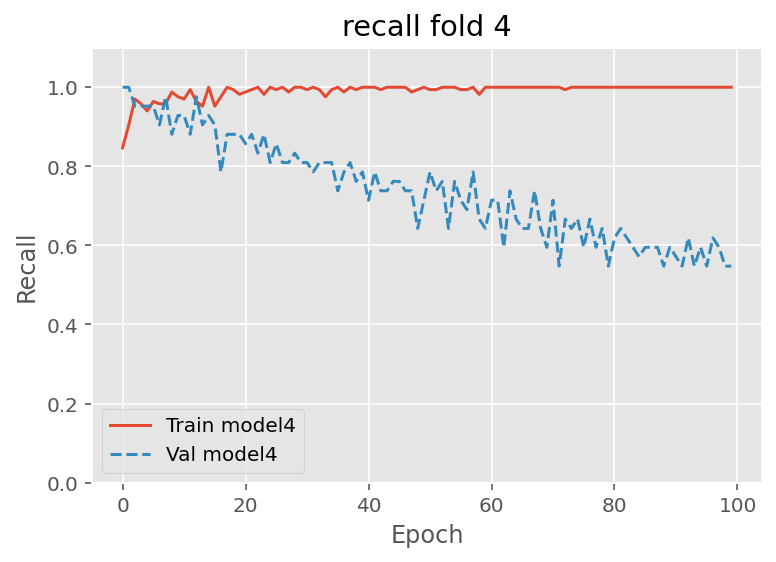

[[843  96]
 [ 19  23]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       939
           1       0.19      0.55      0.29        42

    accuracy                           0.88       981
   macro avg       0.59      0.72      0.61       981
weighted avg       0.94      0.88      0.91       981



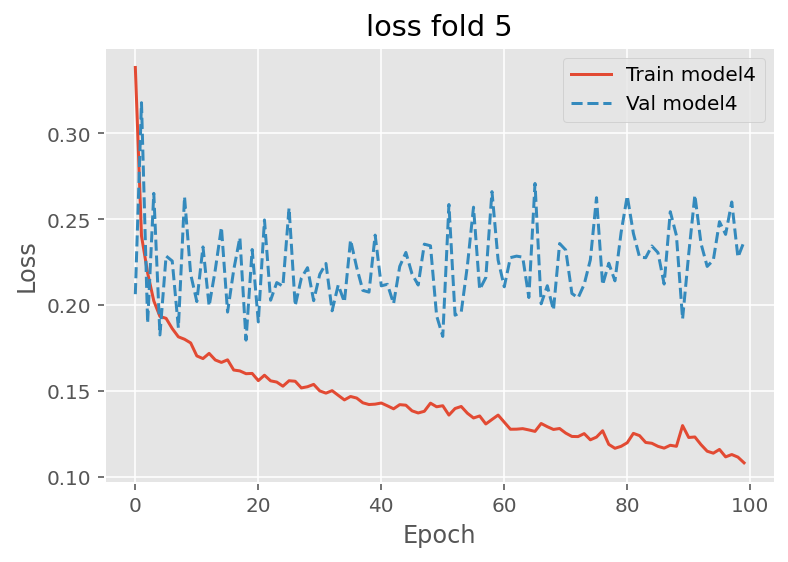

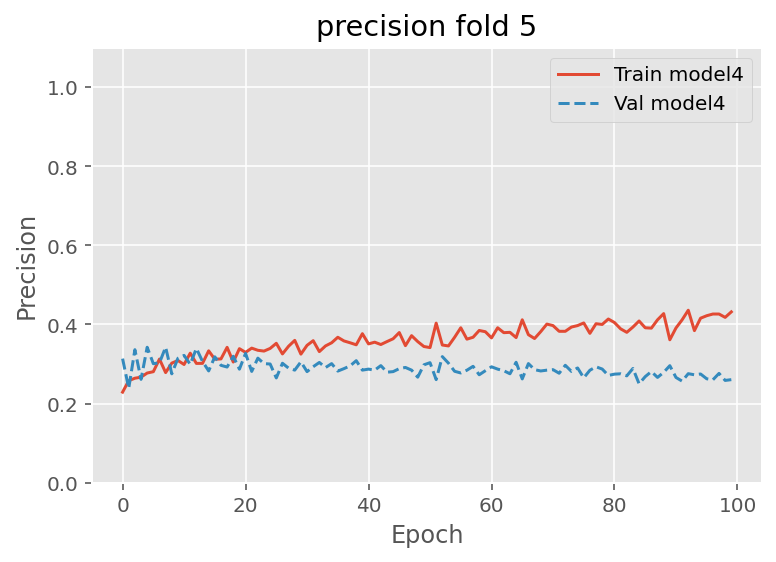

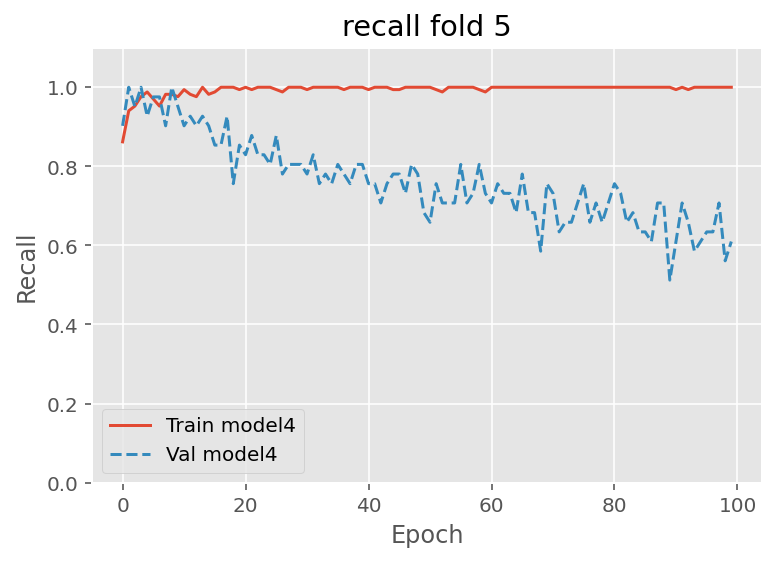

[[869  71]
 [ 16  25]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       940
           1       0.26      0.61      0.36        41

    accuracy                           0.91       981
   macro avg       0.62      0.77      0.66       981
weighted avg       0.95      0.91      0.93       981

model4: mean precision:0.18100986658036708 and standard deviation:0.06381960252804061
model4: mean recall:0.7262508716620504 and standard deviation:0.02845150193443777
model4: mean f1-score:0.28528272260059684 and standard deviation:0.08202104072451911
CPU times: user 50.3 s, sys: 5.29 s, total: 55.6 s
Wall time: 43.8 s


In [52]:
%%time
m4_eval = evaluate_mlp_model(make_model4,input_tensor,predictions,'model4',epochs=100)

### Based on the ROC curve, it seems my MLP model performs better than my wide and deep network model. 

In [53]:
t = 2.26/np.sqrt(10)
e = (1-m1_eval['f1']) - (1-m4_eval['f1'])
print(
    'The different between model1 and model4 is {},{}'.format(np.mean(e)-t*np.std(e),np.mean(e)+t*np.std(e))
)

The different between model1 and model4 is -0.0011303563204823064,0.11718858501331293


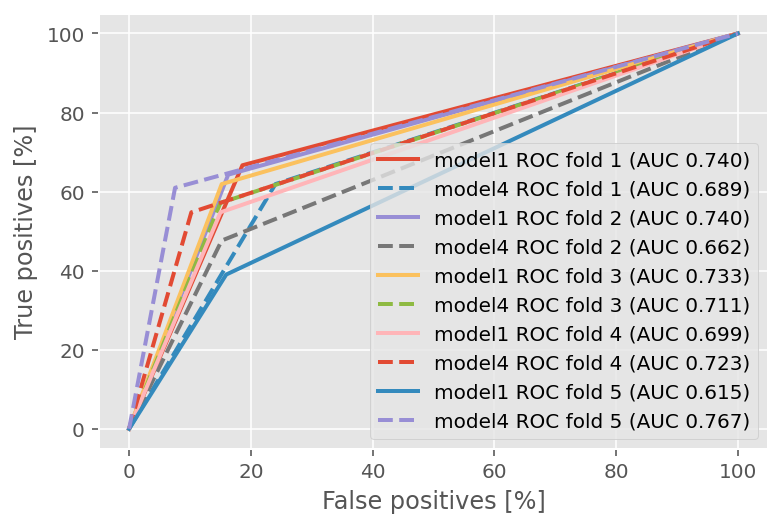

In [54]:
plot_roc(m3_eval,m4_eval,'model1','model4')

## Exceptional Work (1 points total)
- 5000 students: You have free reign to provide additional analyses.
- One idea (required for 7000 level students): Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

In [55]:
X = df[feature_columns].to_numpy()
y = df['stroke'].to_numpy()

X_crossed = df[cross_col_df_names].to_numpy()
# save categorical features
X_cat = df[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_num =  df[numeric_headers].to_numpy()

# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                output_dim=int(np.sqrt(N)), 
                input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
# wide_branch = concatenate(crossed_outputs, name='wide_concat')
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                output_dim=int(np.sqrt(N)), 
                input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_num.shape[1],), name='numeric')
x_dense = Dense(units=10, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=15,activation='relu', name='deep2')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

def make_model1(input_crossed,input_cat,input_num,final_branch):
    model = Model(inputs=[input_crossed,input_cat,input_num], 
                    outputs=final_branch)
    model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=score)
    return model

In [56]:
mode1 = make_model1(input_crossed,input_cat,input_num,final_branch)
h = model1.fit([X_crossed[:1000],X_cat[:1000],X_num[:1000]],
            y[:1000], 
            epochs=100, 
            batch_size=512, 
            verbose=0,
            class_weight = class_weight,
            validation_data = ([X_crossed[:1000],X_cat[:1000],X_num[:1000]],y[:1000]))

In [57]:
mode1.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_input (InputLayer)  [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.compat.v1.gather_32 (TFOpLam (None,)              0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf.compat.v1.gather_33 (TFOpLam (None,)              0           categorical_input[0][0]          
__________________________________________________________________________________________________
tf.compat.v1.gather_34 (TFOpLam (None,)              0           categorical_input[0][0]          
___________________________________________________________________________________________

In [58]:
work_type_dis = df['work_type'][:1000].value_counts()
print(work_type_dis)
work_type_int_dis = df['work_type_int'][:1000].value_counts()
print(work_type_int_dis)

Private          602
Self-employed    174
Govt_job         118
children         101
Never_worked       5
Name: work_type, dtype: int64
2    602
3    174
0    118
4    101
1      5
Name: work_type_int, dtype: int64


In [59]:
w = mode1.get_layer('work_type_int_embed').get_weights()
w = np.array(w).reshape(5,2)
print(w)
print(w.shape)

[[-0.04568279  0.03069908]
 [ 0.02363231  0.0402539 ]
 [-0.02984816 -0.04198415]
 [-0.0171746   0.00376706]
 [ 0.00695238  0.03777257]]
(5, 2)


In [60]:
lable_encoders['work_type'].inverse_transform([0,1,2,3,4])

array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype=object)

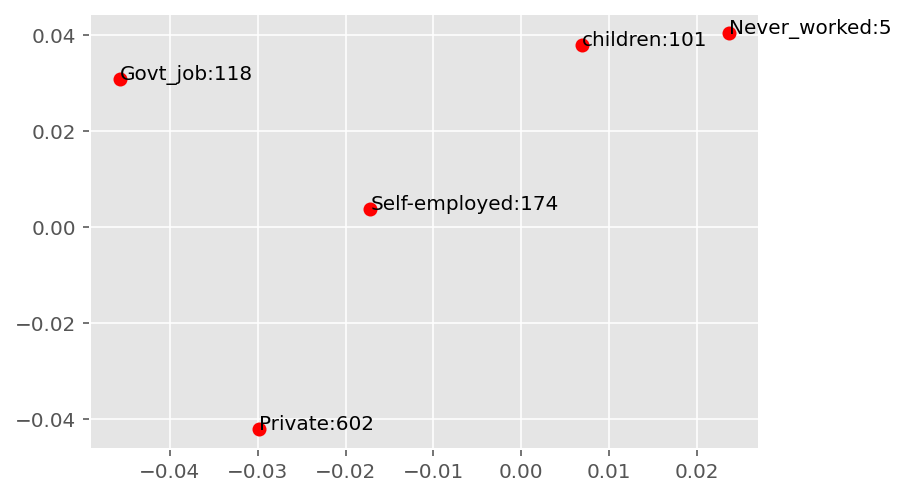

In [61]:
plt.plot(w[:,0],w[:,1],'ro')
for _,idx in enumerate(work_type_int_dis.keys()):
    name = lable_encoders['work_type'].inverse_transform([idx])[0]
    plt.annotate('{}:{}'.format(name,work_type_dis[name]),w[idx])
plt.show()

### I'm not 100% sure about the purpose of this visualization. However, I have a guess, if I have hundreds of work types, then I could do dimention reduction by making the types closer to each other into one type.